---

In [1]:
from pathlib import Path

path = Path().absolute()

In [2]:
cd ../

c:\Users\c10nGp4\OneDrive\Documents\GitHub\imbalance-multi-classification


In [3]:
import pickle
import time

from sklearn.pipeline import Pipeline

---

### Load Data
---

In [4]:
import pandas as pd

# Load dataset
training_set_df = pd.read_csv(path / "assets/datasets/training-set-1.csv", delimiter=";")
testing_set_df = pd.read_csv(path / "assets/datasets/testing-set-1.csv", delimiter=";")

# Get X and y from dataset
X_train = list(training_set_df["texts"])
y_train = list(training_set_df["targets"])

X_test = list(testing_set_df["texts"])
y_test = list(testing_set_df["targets"])

### Data Preparation
---

In [5]:
from pipeline.text_cleaning import TextCleaning
from pipeline.tokenize_mwt_pos_lemma import TokenizeMWTPOSLemma

# Text Preprocessing

text_preprocessing_pipeline: Pipeline = Pipeline([
    ("text_cleaning", TextCleaning()),
    ("tokenize_mwt_pos_lemma", TokenizeMWTPOSLemma())
])

X_train = text_preprocessing_pipeline.transform(X_train)
X_test = text_preprocessing_pipeline.transform(X_test)

2023-06-07 05:53:01 INFO: DOWNLOAD STANZA MODEL


2023-06-07 05:53:02 INFO: Downloading default packages for language: id (Indonesian) ...
2023-06-07 05:53:02 INFO: File exists: C:\Users\c10nGp4\stanza_resources\id\default.zip
2023-06-07 05:53:04 INFO: Finished downloading models and saved to C:\Users\c10nGp4\stanza_resources.
2023-06-07 05:53:04 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-06-07 05:53:04 INFO: LOAD STANZA PIPELINE: tokenize,mwt,pos,lemma


2023-06-07 05:53:11 INFO: Loading these models for language: id (Indonesian):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |

2023-06-07 05:53:11 INFO: Using device: cuda
2023-06-07 05:53:11 INFO: Loading: tokenize
2023-06-07 05:53:13 INFO: Loading: mwt
2023-06-07 05:53:13 INFO: Loading: pos
2023-06-07 05:53:14 INFO: Loading: lemma
2023-06-07 05:53:14 INFO: Done loading processors!


2023-06-07 05:53:14 INFO: TEXT CLEANING
2023-06-07 05:53:15 INFO: TOKENIZE, MWT, POS, LEMMA
2023-06-07 05:54:32 INFO: TEXT CLEANING
2023-06-07 05:54:33 INFO: TOKENIZE, MWT, POS, LEMMA


### Hyper-parameters tuning
---

In [6]:
# from pipeline.stopword_removal import StopWordRemoval

# stopword_removal = StopWordRemoval()

# X_train = stopword_removal.transform(X_train)
# X_test = stopword_removal.transform(X_test)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

from pipeline.pos_filter import POSFilter
from pipeline.document_transformer import DocumentTransformer

def fun(arg):
    return arg

tfidfvectorizer_hyperparameters = {
    "encoding": "ascii",
    "decode_error": "ignore",
    "strip_accents": "ascii",
    "preprocessor": fun,
    "tokenizer": fun,
    "analyzer": "word",
    "token_pattern": None,
    "max_df": 1.0,
}

linearsvc_hyperparameters = {
    "loss": "squared_hinge",
    "dual": False,
    "tol": 0.0001,
    "multi_class": "ovr",
    "max_iter": 1000000,
    "random_state": 42
}

document_transformer_hyperparameters = {
    "feat_attrs": ["text"]
}

pipeline: Pipeline = Pipeline([
    ("pos_filter", POSFilter()),
    ("document_transformer", DocumentTransformer(**document_transformer_hyperparameters)),
    ("tfidfvectorizer", TfidfVectorizer(**tfidfvectorizer_hyperparameters)),
    ("linearsvc", LinearSVC(random_state=42))
])

In [8]:
from pipeline.pos_filter import POS

param_distributions = [
    {
        "pos_filter__pos": (POS, ("ADJ","ADV","NOUN","PART","VERB")),
        "tfidfvectorizer__ngram_range": ((1, 1), (1, 2)),
        "tfidfvectorizer__min_df": (1, 5),
        "tfidfvectorizer__norm": ("l1", "l2"),
        "tfidfvectorizer__sublinear_tf": (True, False),
        "linearsvc__class_weight": (None, "balanced"),
        "linearsvc__penalty": ("l1","l2"),
        "linearsvc__C": (0.1, 1),
        "linearsvc__fit_intercept": (True,),
        "linearsvc__intercept_scaling": (1.0, 1000),
    },
    {
        "pos_filter__pos": (POS, ("ADJ","ADV","NOUN","PART","VERB")),
        "tfidfvectorizer__ngram_range": ((1, 1), (1, 2)),
        "tfidfvectorizer__min_df": (1, 5),
        "tfidfvectorizer__norm": ("l1", "l2"),
        "tfidfvectorizer__sublinear_tf": (True, False),
        "linearsvc__class_weight": (None, "balanced"),
        "linearsvc__penalty": ("l1","l2"),
        "linearsvc__C": (0.1, 1),
        "linearsvc__fit_intercept": (False,)
    }
]

In [9]:
from sklearn.metrics import make_scorer, accuracy_score, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearnex import config_context

n_iter = 1000
n_splits = 5
train_size = 0.8
n_jobs = 1
verbose = 1

randomized_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=make_scorer(matthews_corrcoef),
    n_jobs=n_jobs,
    cv=StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, random_state=42),
    verbose=verbose,
    random_state=42
)

t0 = time.time()

with config_context(target_offload="auto", allow_fallback_to_host=True):
    randomized_search.fit(X_train, y_train)

estimation = time.time() - t0

cv_results_df = pd.DataFrame(randomized_search.cv_results_)

cv_results_df = cv_results_df.rename(lambda col_name: col_name.split("__")[-1] if "param_" in col_name else col_name, axis="columns")
cv_results_df = cv_results_df.reindex(columns=["pos","ngram_range","min_df", "norm","sublinear_tf","class_weight","penalty","C","fit_intercept","intercept_scaling","split0_test_score","split1_test_score","split2_test_score","split3_test_score","split4_test_score","mean_test_score","mean_fit_time","rank_test_score"])
cv_results_df = cv_results_df.fillna("None")

cv_results_df.to_csv(path / "assets/experiment_3_without_stopwords_cv_results.csv", sep=";", index=False)

c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 768 is smaller than n_iter=1000. Running 768 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 768 candidates, totalling 3840 fits
2023-06-07 05:54:58 INFO: POS REMOVAL
2023-06-07 05:54:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 05:54:59 INFO: POS REMOVAL
2023-06-07 05:54:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 05:55:00 INFO: POS REMOVAL
2023-06-07 05:55:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 05:55:01 INFO: POS REMOVAL
2023-06-07 05:55:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 05:55:02 INFO: POS REMOVAL
2023-06-07 05:55:02 INFO: DOCUMENT TRANSFORMER
2023-06-07 05:55:03 INFO: POS REMOVAL
2023-06-07 05:55:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 05:55:04 INFO: POS REMOVAL
2023-06-07 05:55:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 05:55:05 INFO: POS REMOVAL
2023-06-07 05:55:05 INFO: DOCUMENT TRANSFORMER
2023-06-07 05:55:06 INFO: POS REMOVAL
2023-06-07 05:55:06 INFO: DOCUMENT TRANSFORMER
2023-06-07 05:55:07 INFO: POS REMOVAL
2023-06-07 05:55:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 05:55:08 INFO: POS REMOVAL
2023-06-07 05:55:08 INFO: DOCUMENT TRANSFORMER
2

c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:01:37 INFO: POS REMOVAL
2023-06-07 06:01:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:01:37 INFO: POS REMOVAL
2023-06-07 06:01:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:01:40 INFO: POS REMOVAL
2023-06-07 06:01:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:01:40 INFO: POS REMOVAL
2023-06-07 06:01:41 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:01:44 INFO: POS REMOVAL
2023-06-07 06:01:44 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:01:44 INFO: POS REMOVAL
2023-06-07 06:01:44 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:01:47 INFO: POS REMOVAL
2023-06-07 06:01:47 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:01:47 INFO: POS REMOVAL
2023-06-07 06:01:47 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:01:50 INFO: POS REMOVAL
2023-06-07 06:01:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:01:50 INFO: POS REMOVAL
2023-06-07 06:01:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:01:53 INFO: POS REMOVAL
2023-06-07 06:01:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:01:54 INFO: POS REMOVAL
2023-06-07 06:01:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:01:57 INFO: POS REMOVAL
2023-06-07 06:01:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:01:57 INFO: POS REMOVAL
2023-06-07 06:01:57 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:00 INFO: POS REMOVAL
2023-06-07 06:02:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:01 INFO: POS REMOVAL
2023-06-07 06:02:01 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:04 INFO: POS REMOVAL
2023-06-07 06:02:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:04 INFO: POS REMOVAL
2023-06-07 06:02:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:07 INFO: POS REMOVAL
2023-06-07 06:02:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:07 INFO: POS REMOVAL
2023-06-07 06:02:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:10 INFO: POS REMOVAL
2023-06-07 06:02:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:10 INFO: POS REMOVAL
2023-06-07 06:02:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:13 INFO: POS REMOVAL
2023-06-07 06:02:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:13 INFO: POS REMOVAL
2023-06-07 06:02:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:17 INFO: POS REMOVAL
2023-06-07 06:02:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:17 INFO: POS REMOVAL
2023-06-07 06:02:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:20 INFO: POS REMOVAL
2023-06-07 06:02:20 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:20 INFO: POS REMOVAL
2023-06-07 06:02:21 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:24 INFO: POS REMOVAL
2023-06-07 06:02:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:24 INFO: POS REMOVAL
2023-06-07 06:02:24 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:27 INFO: POS REMOVAL
2023-06-07 06:02:27 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:27 INFO: POS REMOVAL
2023-06-07 06:02:27 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:30 INFO: POS REMOVAL
2023-06-07 06:02:30 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:30 INFO: POS REMOVAL
2023-06-07 06:02:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:34 INFO: POS REMOVAL
2023-06-07 06:02:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:34 INFO: POS REMOVAL
2023-06-07 06:02:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:37 INFO: POS REMOVAL
2023-06-07 06:02:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:37 INFO: POS REMOVAL
2023-06-07 06:02:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:40 INFO: POS REMOVAL
2023-06-07 06:02:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:40 INFO: POS REMOVAL
2023-06-07 06:02:41 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:45 INFO: POS REMOVAL
2023-06-07 06:02:45 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:45 INFO: POS REMOVAL
2023-06-07 06:02:45 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:50 INFO: POS REMOVAL
2023-06-07 06:02:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:50 INFO: POS REMOVAL
2023-06-07 06:02:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:54 INFO: POS REMOVAL
2023-06-07 06:02:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:55 INFO: POS REMOVAL
2023-06-07 06:02:55 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:02:59 INFO: POS REMOVAL
2023-06-07 06:02:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:02:59 INFO: POS REMOVAL
2023-06-07 06:02:59 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:04 INFO: POS REMOVAL
2023-06-07 06:03:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:04 INFO: POS REMOVAL
2023-06-07 06:03:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:08 INFO: POS REMOVAL
2023-06-07 06:03:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:09 INFO: POS REMOVAL
2023-06-07 06:03:09 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:13 INFO: POS REMOVAL
2023-06-07 06:03:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:13 INFO: POS REMOVAL
2023-06-07 06:03:13 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:18 INFO: POS REMOVAL
2023-06-07 06:03:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:18 INFO: POS REMOVAL
2023-06-07 06:03:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:22 INFO: POS REMOVAL
2023-06-07 06:03:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:22 INFO: POS REMOVAL
2023-06-07 06:03:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:27 INFO: POS REMOVAL
2023-06-07 06:03:27 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:27 INFO: POS REMOVAL
2023-06-07 06:03:27 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:32 INFO: POS REMOVAL
2023-06-07 06:03:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:32 INFO: POS REMOVAL
2023-06-07 06:03:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:37 INFO: POS REMOVAL
2023-06-07 06:03:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:37 INFO: POS REMOVAL
2023-06-07 06:03:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:41 INFO: POS REMOVAL
2023-06-07 06:03:41 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:41 INFO: POS REMOVAL
2023-06-07 06:03:41 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:45 INFO: POS REMOVAL
2023-06-07 06:03:45 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:45 INFO: POS REMOVAL
2023-06-07 06:03:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:52 INFO: POS REMOVAL
2023-06-07 06:03:52 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:52 INFO: POS REMOVAL
2023-06-07 06:03:52 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:03:59 INFO: POS REMOVAL
2023-06-07 06:03:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:03:59 INFO: POS REMOVAL
2023-06-07 06:03:59 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:05 INFO: POS REMOVAL
2023-06-07 06:04:05 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:06 INFO: POS REMOVAL
2023-06-07 06:04:06 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:12 INFO: POS REMOVAL
2023-06-07 06:04:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:12 INFO: POS REMOVAL
2023-06-07 06:04:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:18 INFO: POS REMOVAL
2023-06-07 06:04:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:19 INFO: POS REMOVAL
2023-06-07 06:04:19 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:25 INFO: POS REMOVAL
2023-06-07 06:04:25 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:25 INFO: POS REMOVAL
2023-06-07 06:04:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:29 INFO: POS REMOVAL
2023-06-07 06:04:29 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:30 INFO: POS REMOVAL
2023-06-07 06:04:30 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:34 INFO: POS REMOVAL
2023-06-07 06:04:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:34 INFO: POS REMOVAL
2023-06-07 06:04:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:37 INFO: POS REMOVAL
2023-06-07 06:04:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:37 INFO: POS REMOVAL
2023-06-07 06:04:38 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:41 INFO: POS REMOVAL
2023-06-07 06:04:41 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:42 INFO: POS REMOVAL
2023-06-07 06:04:42 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:45 INFO: POS REMOVAL
2023-06-07 06:04:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:46 INFO: POS REMOVAL
2023-06-07 06:04:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:49 INFO: POS REMOVAL
2023-06-07 06:04:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:49 INFO: POS REMOVAL
2023-06-07 06:04:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:53 INFO: POS REMOVAL
2023-06-07 06:04:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:53 INFO: POS REMOVAL
2023-06-07 06:04:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:04:58 INFO: POS REMOVAL
2023-06-07 06:04:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:04:58 INFO: POS REMOVAL
2023-06-07 06:04:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:02 INFO: POS REMOVAL
2023-06-07 06:05:02 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:02 INFO: POS REMOVAL
2023-06-07 06:05:02 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:05 INFO: POS REMOVAL
2023-06-07 06:05:05 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:05 INFO: POS REMOVAL
2023-06-07 06:05:06 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:08 INFO: POS REMOVAL
2023-06-07 06:05:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:09 INFO: POS REMOVAL
2023-06-07 06:05:09 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:12 INFO: POS REMOVAL
2023-06-07 06:05:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:12 INFO: POS REMOVAL
2023-06-07 06:05:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:16 INFO: POS REMOVAL
2023-06-07 06:05:16 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:16 INFO: POS REMOVAL
2023-06-07 06:05:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:19 INFO: POS REMOVAL
2023-06-07 06:05:19 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:19 INFO: POS REMOVAL
2023-06-07 06:05:19 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:22 INFO: POS REMOVAL
2023-06-07 06:05:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:22 INFO: POS REMOVAL
2023-06-07 06:05:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:25 INFO: POS REMOVAL
2023-06-07 06:05:25 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:25 INFO: POS REMOVAL
2023-06-07 06:05:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:28 INFO: POS REMOVAL
2023-06-07 06:05:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:28 INFO: POS REMOVAL
2023-06-07 06:05:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:31 INFO: POS REMOVAL
2023-06-07 06:05:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:31 INFO: POS REMOVAL
2023-06-07 06:05:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:34 INFO: POS REMOVAL
2023-06-07 06:05:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:34 INFO: POS REMOVAL
2023-06-07 06:05:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:37 INFO: POS REMOVAL
2023-06-07 06:05:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:37 INFO: POS REMOVAL
2023-06-07 06:05:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:40 INFO: POS REMOVAL
2023-06-07 06:05:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:40 INFO: POS REMOVAL
2023-06-07 06:05:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:44 INFO: POS REMOVAL
2023-06-07 06:05:44 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:44 INFO: POS REMOVAL
2023-06-07 06:05:44 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:47 INFO: POS REMOVAL
2023-06-07 06:05:47 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:47 INFO: POS REMOVAL
2023-06-07 06:05:47 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:51 INFO: POS REMOVAL
2023-06-07 06:05:51 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:51 INFO: POS REMOVAL
2023-06-07 06:05:51 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:54 INFO: POS REMOVAL
2023-06-07 06:05:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:54 INFO: POS REMOVAL
2023-06-07 06:05:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:05:58 INFO: POS REMOVAL
2023-06-07 06:05:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:05:58 INFO: POS REMOVAL
2023-06-07 06:05:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:01 INFO: POS REMOVAL
2023-06-07 06:06:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:01 INFO: POS REMOVAL
2023-06-07 06:06:01 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:04 INFO: POS REMOVAL
2023-06-07 06:06:05 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:05 INFO: POS REMOVAL
2023-06-07 06:06:05 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:08 INFO: POS REMOVAL
2023-06-07 06:06:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:08 INFO: POS REMOVAL
2023-06-07 06:06:08 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:11 INFO: POS REMOVAL
2023-06-07 06:06:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:11 INFO: POS REMOVAL
2023-06-07 06:06:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:15 INFO: POS REMOVAL
2023-06-07 06:06:15 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:15 INFO: POS REMOVAL
2023-06-07 06:06:15 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:18 INFO: POS REMOVAL
2023-06-07 06:06:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:18 INFO: POS REMOVAL
2023-06-07 06:06:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:23 INFO: POS REMOVAL
2023-06-07 06:06:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:23 INFO: POS REMOVAL
2023-06-07 06:06:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:28 INFO: POS REMOVAL
2023-06-07 06:06:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:28 INFO: POS REMOVAL
2023-06-07 06:06:29 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:34 INFO: POS REMOVAL
2023-06-07 06:06:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:34 INFO: POS REMOVAL
2023-06-07 06:06:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:40 INFO: POS REMOVAL
2023-06-07 06:06:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:40 INFO: POS REMOVAL
2023-06-07 06:06:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:44 INFO: POS REMOVAL
2023-06-07 06:06:44 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:44 INFO: POS REMOVAL
2023-06-07 06:06:44 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:47 INFO: POS REMOVAL
2023-06-07 06:06:47 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:47 INFO: POS REMOVAL
2023-06-07 06:06:47 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:51 INFO: POS REMOVAL
2023-06-07 06:06:51 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:51 INFO: POS REMOVAL
2023-06-07 06:06:51 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:54 INFO: POS REMOVAL
2023-06-07 06:06:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:54 INFO: POS REMOVAL
2023-06-07 06:06:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:06:57 INFO: POS REMOVAL
2023-06-07 06:06:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:06:57 INFO: POS REMOVAL
2023-06-07 06:06:57 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:00 INFO: POS REMOVAL
2023-06-07 06:07:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:01 INFO: POS REMOVAL
2023-06-07 06:07:01 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:04 INFO: POS REMOVAL
2023-06-07 06:07:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:04 INFO: POS REMOVAL
2023-06-07 06:07:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:07 INFO: POS REMOVAL
2023-06-07 06:07:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:07 INFO: POS REMOVAL
2023-06-07 06:07:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:10 INFO: POS REMOVAL
2023-06-07 06:07:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:10 INFO: POS REMOVAL
2023-06-07 06:07:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:13 INFO: POS REMOVAL
2023-06-07 06:07:14 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:14 INFO: POS REMOVAL
2023-06-07 06:07:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:17 INFO: POS REMOVAL
2023-06-07 06:07:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:17 INFO: POS REMOVAL
2023-06-07 06:07:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:21 INFO: POS REMOVAL
2023-06-07 06:07:21 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:21 INFO: POS REMOVAL
2023-06-07 06:07:21 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:26 INFO: POS REMOVAL
2023-06-07 06:07:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:26 INFO: POS REMOVAL
2023-06-07 06:07:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:31 INFO: POS REMOVAL
2023-06-07 06:07:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:31 INFO: POS REMOVAL
2023-06-07 06:07:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:36 INFO: POS REMOVAL
2023-06-07 06:07:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:36 INFO: POS REMOVAL
2023-06-07 06:07:36 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:41 INFO: POS REMOVAL
2023-06-07 06:07:41 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:41 INFO: POS REMOVAL
2023-06-07 06:07:41 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:46 INFO: POS REMOVAL
2023-06-07 06:07:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:46 INFO: POS REMOVAL
2023-06-07 06:07:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:51 INFO: POS REMOVAL
2023-06-07 06:07:51 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:51 INFO: POS REMOVAL
2023-06-07 06:07:51 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:07:56 INFO: POS REMOVAL
2023-06-07 06:07:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:07:56 INFO: POS REMOVAL
2023-06-07 06:07:56 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:08:01 INFO: POS REMOVAL
2023-06-07 06:08:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:08:01 INFO: POS REMOVAL
2023-06-07 06:08:01 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:08:06 INFO: POS REMOVAL
2023-06-07 06:08:06 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:08:07 INFO: POS REMOVAL
2023-06-07 06:08:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:08:12 INFO: POS REMOVAL
2023-06-07 06:08:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:08:12 INFO: POS REMOVAL
2023-06-07 06:08:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:08:17 INFO: POS REMOVAL
2023-06-07 06:08:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:08:17 INFO: POS REMOVAL
2023-06-07 06:08:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:08:22 INFO: POS REMOVAL
2023-06-07 06:08:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:08:22 INFO: POS REMOVAL
2023-06-07 06:08:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:08:30 INFO: POS REMOVAL
2023-06-07 06:08:30 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:08:30 INFO: POS REMOVAL
2023-06-07 06:08:30 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:08:38 INFO: POS REMOVAL
2023-06-07 06:08:38 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:08:38 INFO: POS REMOVAL
2023-06-07 06:08:38 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:08:46 INFO: POS REMOVAL
2023-06-07 06:08:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:08:46 INFO: POS REMOVAL
2023-06-07 06:08:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:08:54 INFO: POS REMOVAL
2023-06-07 06:08:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:08:54 INFO: POS REMOVAL
2023-06-07 06:08:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:09:02 INFO: POS REMOVAL
2023-06-07 06:09:02 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:09:02 INFO: POS REMOVAL
2023-06-07 06:09:02 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:09:10 INFO: POS REMOVAL
2023-06-07 06:09:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:09:10 INFO: POS REMOVAL
2023-06-07 06:09:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:09:18 INFO: POS REMOVAL
2023-06-07 06:09:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:09:18 INFO: POS REMOVAL
2023-06-07 06:09:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:09:26 INFO: POS REMOVAL
2023-06-07 06:09:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:09:26 INFO: POS REMOVAL
2023-06-07 06:09:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:09:34 INFO: POS REMOVAL
2023-06-07 06:09:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:09:34 INFO: POS REMOVAL
2023-06-07 06:09:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:09:42 INFO: POS REMOVAL
2023-06-07 06:09:42 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:09:42 INFO: POS REMOVAL
2023-06-07 06:09:42 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:09:50 INFO: POS REMOVAL
2023-06-07 06:09:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:09:50 INFO: POS REMOVAL
2023-06-07 06:09:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:09:58 INFO: POS REMOVAL
2023-06-07 06:09:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:09:58 INFO: POS REMOVAL
2023-06-07 06:09:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:05 INFO: POS REMOVAL
2023-06-07 06:10:05 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:06 INFO: POS REMOVAL
2023-06-07 06:10:06 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:13 INFO: POS REMOVAL
2023-06-07 06:10:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:14 INFO: POS REMOVAL
2023-06-07 06:10:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:20 INFO: POS REMOVAL
2023-06-07 06:10:20 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:21 INFO: POS REMOVAL
2023-06-07 06:10:21 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:25 INFO: POS REMOVAL
2023-06-07 06:10:25 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:25 INFO: POS REMOVAL
2023-06-07 06:10:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:30 INFO: POS REMOVAL
2023-06-07 06:10:30 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:30 INFO: POS REMOVAL
2023-06-07 06:10:30 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:35 INFO: POS REMOVAL
2023-06-07 06:10:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:35 INFO: POS REMOVAL
2023-06-07 06:10:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:40 INFO: POS REMOVAL
2023-06-07 06:10:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:40 INFO: POS REMOVAL
2023-06-07 06:10:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:44 INFO: POS REMOVAL
2023-06-07 06:10:44 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:44 INFO: POS REMOVAL
2023-06-07 06:10:45 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:47 INFO: POS REMOVAL
2023-06-07 06:10:47 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:48 INFO: POS REMOVAL
2023-06-07 06:10:48 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:51 INFO: POS REMOVAL
2023-06-07 06:10:51 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:51 INFO: POS REMOVAL
2023-06-07 06:10:51 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:54 INFO: POS REMOVAL
2023-06-07 06:10:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:54 INFO: POS REMOVAL
2023-06-07 06:10:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:10:57 INFO: POS REMOVAL
2023-06-07 06:10:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:10:57 INFO: POS REMOVAL
2023-06-07 06:10:57 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:00 INFO: POS REMOVAL
2023-06-07 06:11:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:00 INFO: POS REMOVAL
2023-06-07 06:11:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:03 INFO: POS REMOVAL
2023-06-07 06:11:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:03 INFO: POS REMOVAL
2023-06-07 06:11:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:06 INFO: POS REMOVAL
2023-06-07 06:11:06 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:06 INFO: POS REMOVAL
2023-06-07 06:11:06 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:09 INFO: POS REMOVAL
2023-06-07 06:11:09 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:09 INFO: POS REMOVAL
2023-06-07 06:11:09 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:12 INFO: POS REMOVAL
2023-06-07 06:11:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:12 INFO: POS REMOVAL
2023-06-07 06:11:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:15 INFO: POS REMOVAL
2023-06-07 06:11:15 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:15 INFO: POS REMOVAL
2023-06-07 06:11:15 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:18 INFO: POS REMOVAL
2023-06-07 06:11:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:18 INFO: POS REMOVAL
2023-06-07 06:11:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:21 INFO: POS REMOVAL
2023-06-07 06:11:21 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:21 INFO: POS REMOVAL
2023-06-07 06:11:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:24 INFO: POS REMOVAL
2023-06-07 06:11:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:25 INFO: POS REMOVAL
2023-06-07 06:11:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:28 INFO: POS REMOVAL
2023-06-07 06:11:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:28 INFO: POS REMOVAL
2023-06-07 06:11:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:31 INFO: POS REMOVAL
2023-06-07 06:11:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:31 INFO: POS REMOVAL
2023-06-07 06:11:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:34 INFO: POS REMOVAL
2023-06-07 06:11:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:34 INFO: POS REMOVAL
2023-06-07 06:11:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:37 INFO: POS REMOVAL
2023-06-07 06:11:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:37 INFO: POS REMOVAL
2023-06-07 06:11:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:40 INFO: POS REMOVAL
2023-06-07 06:11:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:40 INFO: POS REMOVAL
2023-06-07 06:11:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:43 INFO: POS REMOVAL
2023-06-07 06:11:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:43 INFO: POS REMOVAL
2023-06-07 06:11:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:46 INFO: POS REMOVAL
2023-06-07 06:11:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:46 INFO: POS REMOVAL
2023-06-07 06:11:47 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:50 INFO: POS REMOVAL
2023-06-07 06:11:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:50 INFO: POS REMOVAL
2023-06-07 06:11:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:54 INFO: POS REMOVAL
2023-06-07 06:11:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:54 INFO: POS REMOVAL
2023-06-07 06:11:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:11:57 INFO: POS REMOVAL
2023-06-07 06:11:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:11:57 INFO: POS REMOVAL
2023-06-07 06:11:57 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:01 INFO: POS REMOVAL
2023-06-07 06:12:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:01 INFO: POS REMOVAL
2023-06-07 06:12:01 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:04 INFO: POS REMOVAL
2023-06-07 06:12:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:04 INFO: POS REMOVAL
2023-06-07 06:12:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:07 INFO: POS REMOVAL
2023-06-07 06:12:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:08 INFO: POS REMOVAL
2023-06-07 06:12:08 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:11 INFO: POS REMOVAL
2023-06-07 06:12:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:11 INFO: POS REMOVAL
2023-06-07 06:12:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:14 INFO: POS REMOVAL
2023-06-07 06:12:14 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:14 INFO: POS REMOVAL
2023-06-07 06:12:15 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:18 INFO: POS REMOVAL
2023-06-07 06:12:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:18 INFO: POS REMOVAL
2023-06-07 06:12:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:21 INFO: POS REMOVAL
2023-06-07 06:12:21 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:21 INFO: POS REMOVAL
2023-06-07 06:12:21 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:25 INFO: POS REMOVAL
2023-06-07 06:12:25 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:25 INFO: POS REMOVAL
2023-06-07 06:12:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:28 INFO: POS REMOVAL
2023-06-07 06:12:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:28 INFO: POS REMOVAL
2023-06-07 06:12:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:31 INFO: POS REMOVAL
2023-06-07 06:12:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:32 INFO: POS REMOVAL
2023-06-07 06:12:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:35 INFO: POS REMOVAL
2023-06-07 06:12:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:35 INFO: POS REMOVAL
2023-06-07 06:12:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:38 INFO: POS REMOVAL
2023-06-07 06:12:38 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:39 INFO: POS REMOVAL
2023-06-07 06:12:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:42 INFO: POS REMOVAL
2023-06-07 06:12:42 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:42 INFO: POS REMOVAL
2023-06-07 06:12:42 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:45 INFO: POS REMOVAL
2023-06-07 06:12:45 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:45 INFO: POS REMOVAL
2023-06-07 06:12:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:49 INFO: POS REMOVAL
2023-06-07 06:12:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:49 INFO: POS REMOVAL
2023-06-07 06:12:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:52 INFO: POS REMOVAL
2023-06-07 06:12:52 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:53 INFO: POS REMOVAL
2023-06-07 06:12:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:12:56 INFO: POS REMOVAL
2023-06-07 06:12:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:56 INFO: POS REMOVAL
2023-06-07 06:12:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:56 INFO: POS REMOVAL
2023-06-07 06:12:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:57 INFO: POS REMOVAL
2023-06-07 06:12:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:57 INFO: POS REMOVAL
2023-06-07 06:12:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:58 INFO: POS REMOVAL
2023-06-07 06:12:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:58 INFO: POS REMOVAL
2023-06-07 06:12:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:58 INFO: POS REMOVAL
2023-06-07 06:12:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:59 INFO: POS REMOVAL
2023-06-07 06:12:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:12:59 INFO: POS REMOVAL
2023-06-07 06:12:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:13:00 INFO: POS REMOVAL
2023-06-07 06:13:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:13:00 INFO: POS REMOVAL
2023-06-07 06:13:00 INFO: D

c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:10 INFO: POS REMOVAL
2023-06-07 06:17:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:10 INFO: POS REMOVAL
2023-06-07 06:17:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:13 INFO: POS REMOVAL
2023-06-07 06:17:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:13 INFO: POS REMOVAL
2023-06-07 06:17:13 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:16 INFO: POS REMOVAL
2023-06-07 06:17:16 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:16 INFO: POS REMOVAL
2023-06-07 06:17:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:19 INFO: POS REMOVAL
2023-06-07 06:17:19 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:20 INFO: POS REMOVAL
2023-06-07 06:17:20 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:23 INFO: POS REMOVAL
2023-06-07 06:17:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:23 INFO: POS REMOVAL
2023-06-07 06:17:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:26 INFO: POS REMOVAL
2023-06-07 06:17:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:27 INFO: POS REMOVAL
2023-06-07 06:17:27 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:30 INFO: POS REMOVAL
2023-06-07 06:17:30 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:30 INFO: POS REMOVAL
2023-06-07 06:17:30 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:33 INFO: POS REMOVAL
2023-06-07 06:17:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:33 INFO: POS REMOVAL
2023-06-07 06:17:33 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:36 INFO: POS REMOVAL
2023-06-07 06:17:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:36 INFO: POS REMOVAL
2023-06-07 06:17:36 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:40 INFO: POS REMOVAL
2023-06-07 06:17:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:40 INFO: POS REMOVAL
2023-06-07 06:17:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:43 INFO: POS REMOVAL
2023-06-07 06:17:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:43 INFO: POS REMOVAL
2023-06-07 06:17:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:46 INFO: POS REMOVAL
2023-06-07 06:17:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:47 INFO: POS REMOVAL
2023-06-07 06:17:47 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:50 INFO: POS REMOVAL
2023-06-07 06:17:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:50 INFO: POS REMOVAL
2023-06-07 06:17:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:53 INFO: POS REMOVAL
2023-06-07 06:17:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:53 INFO: POS REMOVAL
2023-06-07 06:17:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:17:56 INFO: POS REMOVAL
2023-06-07 06:17:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:17:57 INFO: POS REMOVAL
2023-06-07 06:17:57 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:00 INFO: POS REMOVAL
2023-06-07 06:18:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:00 INFO: POS REMOVAL
2023-06-07 06:18:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:03 INFO: POS REMOVAL
2023-06-07 06:18:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:03 INFO: POS REMOVAL
2023-06-07 06:18:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:06 INFO: POS REMOVAL
2023-06-07 06:18:06 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:06 INFO: POS REMOVAL
2023-06-07 06:18:06 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:09 INFO: POS REMOVAL
2023-06-07 06:18:09 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:10 INFO: POS REMOVAL
2023-06-07 06:18:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:13 INFO: POS REMOVAL
2023-06-07 06:18:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:13 INFO: POS REMOVAL
2023-06-07 06:18:13 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:17 INFO: POS REMOVAL
2023-06-07 06:18:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:17 INFO: POS REMOVAL
2023-06-07 06:18:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:22 INFO: POS REMOVAL
2023-06-07 06:18:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:22 INFO: POS REMOVAL
2023-06-07 06:18:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:26 INFO: POS REMOVAL
2023-06-07 06:18:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:27 INFO: POS REMOVAL
2023-06-07 06:18:27 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:31 INFO: POS REMOVAL
2023-06-07 06:18:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:31 INFO: POS REMOVAL
2023-06-07 06:18:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:36 INFO: POS REMOVAL
2023-06-07 06:18:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:36 INFO: POS REMOVAL
2023-06-07 06:18:36 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:40 INFO: POS REMOVAL
2023-06-07 06:18:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:40 INFO: POS REMOVAL
2023-06-07 06:18:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:45 INFO: POS REMOVAL
2023-06-07 06:18:45 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:45 INFO: POS REMOVAL
2023-06-07 06:18:45 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:50 INFO: POS REMOVAL
2023-06-07 06:18:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:50 INFO: POS REMOVAL
2023-06-07 06:18:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:18:55 INFO: POS REMOVAL
2023-06-07 06:18:55 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:18:55 INFO: POS REMOVAL
2023-06-07 06:18:55 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:00 INFO: POS REMOVAL
2023-06-07 06:19:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:00 INFO: POS REMOVAL
2023-06-07 06:19:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:04 INFO: POS REMOVAL
2023-06-07 06:19:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:04 INFO: POS REMOVAL
2023-06-07 06:19:05 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:09 INFO: POS REMOVAL
2023-06-07 06:19:09 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:09 INFO: POS REMOVAL
2023-06-07 06:19:09 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:14 INFO: POS REMOVAL
2023-06-07 06:19:14 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:14 INFO: POS REMOVAL
2023-06-07 06:19:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:18 INFO: POS REMOVAL
2023-06-07 06:19:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:18 INFO: POS REMOVAL
2023-06-07 06:19:19 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:23 INFO: POS REMOVAL
2023-06-07 06:19:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:23 INFO: POS REMOVAL
2023-06-07 06:19:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:28 INFO: POS REMOVAL
2023-06-07 06:19:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:28 INFO: POS REMOVAL
2023-06-07 06:19:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:33 INFO: POS REMOVAL
2023-06-07 06:19:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:33 INFO: POS REMOVAL
2023-06-07 06:19:33 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:37 INFO: POS REMOVAL
2023-06-07 06:19:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:37 INFO: POS REMOVAL
2023-06-07 06:19:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:42 INFO: POS REMOVAL
2023-06-07 06:19:42 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:42 INFO: POS REMOVAL
2023-06-07 06:19:42 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:47 INFO: POS REMOVAL
2023-06-07 06:19:47 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:47 INFO: POS REMOVAL
2023-06-07 06:19:47 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:50 INFO: POS REMOVAL
2023-06-07 06:19:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:50 INFO: POS REMOVAL
2023-06-07 06:19:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:53 INFO: POS REMOVAL
2023-06-07 06:19:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:53 INFO: POS REMOVAL
2023-06-07 06:19:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:56 INFO: POS REMOVAL
2023-06-07 06:19:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:19:56 INFO: POS REMOVAL
2023-06-07 06:19:57 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:19:59 INFO: POS REMOVAL
2023-06-07 06:20:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:00 INFO: POS REMOVAL
2023-06-07 06:20:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:03 INFO: POS REMOVAL
2023-06-07 06:20:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:03 INFO: POS REMOVAL
2023-06-07 06:20:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:06 INFO: POS REMOVAL
2023-06-07 06:20:06 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:06 INFO: POS REMOVAL
2023-06-07 06:20:06 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:09 INFO: POS REMOVAL
2023-06-07 06:20:09 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:09 INFO: POS REMOVAL
2023-06-07 06:20:09 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:12 INFO: POS REMOVAL
2023-06-07 06:20:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:12 INFO: POS REMOVAL
2023-06-07 06:20:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:15 INFO: POS REMOVAL
2023-06-07 06:20:15 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:15 INFO: POS REMOVAL
2023-06-07 06:20:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:19 INFO: POS REMOVAL
2023-06-07 06:20:19 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:19 INFO: POS REMOVAL
2023-06-07 06:20:19 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:22 INFO: POS REMOVAL
2023-06-07 06:20:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:22 INFO: POS REMOVAL
2023-06-07 06:20:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:25 INFO: POS REMOVAL
2023-06-07 06:20:25 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:25 INFO: POS REMOVAL
2023-06-07 06:20:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:28 INFO: POS REMOVAL
2023-06-07 06:20:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:28 INFO: POS REMOVAL
2023-06-07 06:20:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:31 INFO: POS REMOVAL
2023-06-07 06:20:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:31 INFO: POS REMOVAL
2023-06-07 06:20:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:34 INFO: POS REMOVAL
2023-06-07 06:20:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:34 INFO: POS REMOVAL
2023-06-07 06:20:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:37 INFO: POS REMOVAL
2023-06-07 06:20:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:37 INFO: POS REMOVAL
2023-06-07 06:20:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:40 INFO: POS REMOVAL
2023-06-07 06:20:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:40 INFO: POS REMOVAL
2023-06-07 06:20:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:43 INFO: POS REMOVAL
2023-06-07 06:20:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:44 INFO: POS REMOVAL
2023-06-07 06:20:44 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:47 INFO: POS REMOVAL
2023-06-07 06:20:47 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:47 INFO: POS REMOVAL
2023-06-07 06:20:47 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:50 INFO: POS REMOVAL
2023-06-07 06:20:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:50 INFO: POS REMOVAL
2023-06-07 06:20:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:53 INFO: POS REMOVAL
2023-06-07 06:20:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:53 INFO: POS REMOVAL
2023-06-07 06:20:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:20:57 INFO: POS REMOVAL
2023-06-07 06:20:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:20:57 INFO: POS REMOVAL
2023-06-07 06:20:57 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:00 INFO: POS REMOVAL
2023-06-07 06:21:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:00 INFO: POS REMOVAL
2023-06-07 06:21:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:04 INFO: POS REMOVAL
2023-06-07 06:21:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:04 INFO: POS REMOVAL
2023-06-07 06:21:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:07 INFO: POS REMOVAL
2023-06-07 06:21:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:07 INFO: POS REMOVAL
2023-06-07 06:21:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:11 INFO: POS REMOVAL
2023-06-07 06:21:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:11 INFO: POS REMOVAL
2023-06-07 06:21:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:14 INFO: POS REMOVAL
2023-06-07 06:21:14 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:14 INFO: POS REMOVAL
2023-06-07 06:21:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:18 INFO: POS REMOVAL
2023-06-07 06:21:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:18 INFO: POS REMOVAL
2023-06-07 06:21:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:22 INFO: POS REMOVAL
2023-06-07 06:21:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:22 INFO: POS REMOVAL
2023-06-07 06:21:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:26 INFO: POS REMOVAL
2023-06-07 06:21:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:26 INFO: POS REMOVAL
2023-06-07 06:21:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:31 INFO: POS REMOVAL
2023-06-07 06:21:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:32 INFO: POS REMOVAL
2023-06-07 06:21:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:37 INFO: POS REMOVAL
2023-06-07 06:21:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:37 INFO: POS REMOVAL
2023-06-07 06:21:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:43 INFO: POS REMOVAL
2023-06-07 06:21:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:43 INFO: POS REMOVAL
2023-06-07 06:21:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:49 INFO: POS REMOVAL
2023-06-07 06:21:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:49 INFO: POS REMOVAL
2023-06-07 06:21:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:21:54 INFO: POS REMOVAL
2023-06-07 06:21:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:21:54 INFO: POS REMOVAL
2023-06-07 06:21:55 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:00 INFO: POS REMOVAL
2023-06-07 06:22:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:00 INFO: POS REMOVAL
2023-06-07 06:22:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:06 INFO: POS REMOVAL
2023-06-07 06:22:06 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:06 INFO: POS REMOVAL
2023-06-07 06:22:06 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:11 INFO: POS REMOVAL
2023-06-07 06:22:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:11 INFO: POS REMOVAL
2023-06-07 06:22:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:17 INFO: POS REMOVAL
2023-06-07 06:22:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:17 INFO: POS REMOVAL
2023-06-07 06:22:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:22 INFO: POS REMOVAL
2023-06-07 06:22:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:23 INFO: POS REMOVAL
2023-06-07 06:22:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:28 INFO: POS REMOVAL
2023-06-07 06:22:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:28 INFO: POS REMOVAL
2023-06-07 06:22:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:33 INFO: POS REMOVAL
2023-06-07 06:22:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:33 INFO: POS REMOVAL
2023-06-07 06:22:33 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:38 INFO: POS REMOVAL
2023-06-07 06:22:38 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:38 INFO: POS REMOVAL
2023-06-07 06:22:38 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:43 INFO: POS REMOVAL
2023-06-07 06:22:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:43 INFO: POS REMOVAL
2023-06-07 06:22:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:48 INFO: POS REMOVAL
2023-06-07 06:22:48 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:49 INFO: POS REMOVAL
2023-06-07 06:22:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:53 INFO: POS REMOVAL
2023-06-07 06:22:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:54 INFO: POS REMOVAL
2023-06-07 06:22:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:22:59 INFO: POS REMOVAL
2023-06-07 06:22:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:22:59 INFO: POS REMOVAL
2023-06-07 06:22:59 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:04 INFO: POS REMOVAL
2023-06-07 06:23:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:04 INFO: POS REMOVAL
2023-06-07 06:23:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:09 INFO: POS REMOVAL
2023-06-07 06:23:09 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:09 INFO: POS REMOVAL
2023-06-07 06:23:09 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:14 INFO: POS REMOVAL
2023-06-07 06:23:14 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:14 INFO: POS REMOVAL
2023-06-07 06:23:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:19 INFO: POS REMOVAL
2023-06-07 06:23:19 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:19 INFO: POS REMOVAL
2023-06-07 06:23:19 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:24 INFO: POS REMOVAL
2023-06-07 06:23:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:24 INFO: POS REMOVAL
2023-06-07 06:23:24 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:29 INFO: POS REMOVAL
2023-06-07 06:23:29 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:29 INFO: POS REMOVAL
2023-06-07 06:23:29 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:34 INFO: POS REMOVAL
2023-06-07 06:23:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:34 INFO: POS REMOVAL
2023-06-07 06:23:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:39 INFO: POS REMOVAL
2023-06-07 06:23:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:39 INFO: POS REMOVAL
2023-06-07 06:23:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:44 INFO: POS REMOVAL
2023-06-07 06:23:44 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:44 INFO: POS REMOVAL
2023-06-07 06:23:44 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:49 INFO: POS REMOVAL
2023-06-07 06:23:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:49 INFO: POS REMOVAL
2023-06-07 06:23:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:53 INFO: POS REMOVAL
2023-06-07 06:23:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:53 INFO: POS REMOVAL
2023-06-07 06:23:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:23:58 INFO: POS REMOVAL
2023-06-07 06:23:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:23:58 INFO: POS REMOVAL
2023-06-07 06:23:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:24:03 INFO: POS REMOVAL
2023-06-07 06:24:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:24:03 INFO: POS REMOVAL
2023-06-07 06:24:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:24:10 INFO: POS REMOVAL
2023-06-07 06:24:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:24:10 INFO: POS REMOVAL
2023-06-07 06:24:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:24:18 INFO: POS REMOVAL
2023-06-07 06:24:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:24:18 INFO: POS REMOVAL
2023-06-07 06:24:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:24:25 INFO: POS REMOVAL
2023-06-07 06:24:25 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:24:25 INFO: POS REMOVAL
2023-06-07 06:24:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:24:33 INFO: POS REMOVAL
2023-06-07 06:24:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:24:33 INFO: POS REMOVAL
2023-06-07 06:24:33 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:24:40 INFO: POS REMOVAL
2023-06-07 06:24:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:24:40 INFO: POS REMOVAL
2023-06-07 06:24:41 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:24:48 INFO: POS REMOVAL
2023-06-07 06:24:48 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:24:48 INFO: POS REMOVAL
2023-06-07 06:24:48 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:24:55 INFO: POS REMOVAL
2023-06-07 06:24:55 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:24:55 INFO: POS REMOVAL
2023-06-07 06:24:56 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:25:01 INFO: POS REMOVAL
2023-06-07 06:25:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:25:01 INFO: POS REMOVAL
2023-06-07 06:25:02 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:25:09 INFO: POS REMOVAL
2023-06-07 06:25:09 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:25:09 INFO: POS REMOVAL
2023-06-07 06:25:09 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:25:16 INFO: POS REMOVAL
2023-06-07 06:25:16 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:25:16 INFO: POS REMOVAL
2023-06-07 06:25:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:25:24 INFO: POS REMOVAL
2023-06-07 06:25:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:25:24 INFO: POS REMOVAL
2023-06-07 06:25:24 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:25:31 INFO: POS REMOVAL
2023-06-07 06:25:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:25:31 INFO: POS REMOVAL
2023-06-07 06:25:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:25:38 INFO: POS REMOVAL
2023-06-07 06:25:38 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:25:39 INFO: POS REMOVAL
2023-06-07 06:25:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:25:46 INFO: POS REMOVAL
2023-06-07 06:25:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:25:46 INFO: POS REMOVAL
2023-06-07 06:25:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:25:53 INFO: POS REMOVAL
2023-06-07 06:25:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:25:54 INFO: POS REMOVAL
2023-06-07 06:25:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:01 INFO: POS REMOVAL
2023-06-07 06:26:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:01 INFO: POS REMOVAL
2023-06-07 06:26:01 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:09 INFO: POS REMOVAL
2023-06-07 06:26:09 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:09 INFO: POS REMOVAL
2023-06-07 06:26:09 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:16 INFO: POS REMOVAL
2023-06-07 06:26:16 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:16 INFO: POS REMOVAL
2023-06-07 06:26:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:23 INFO: POS REMOVAL
2023-06-07 06:26:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:24 INFO: POS REMOVAL
2023-06-07 06:26:24 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:31 INFO: POS REMOVAL
2023-06-07 06:26:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:31 INFO: POS REMOVAL
2023-06-07 06:26:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:36 INFO: POS REMOVAL
2023-06-07 06:26:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:36 INFO: POS REMOVAL
2023-06-07 06:26:36 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:40 INFO: POS REMOVAL
2023-06-07 06:26:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:40 INFO: POS REMOVAL
2023-06-07 06:26:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:45 INFO: POS REMOVAL
2023-06-07 06:26:45 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:45 INFO: POS REMOVAL
2023-06-07 06:26:45 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:49 INFO: POS REMOVAL
2023-06-07 06:26:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:49 INFO: POS REMOVAL
2023-06-07 06:26:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:54 INFO: POS REMOVAL
2023-06-07 06:26:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:54 INFO: POS REMOVAL
2023-06-07 06:26:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:26:58 INFO: POS REMOVAL
2023-06-07 06:26:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:26:59 INFO: POS REMOVAL
2023-06-07 06:26:59 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:03 INFO: POS REMOVAL
2023-06-07 06:27:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:03 INFO: POS REMOVAL
2023-06-07 06:27:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:08 INFO: POS REMOVAL
2023-06-07 06:27:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:08 INFO: POS REMOVAL
2023-06-07 06:27:08 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:12 INFO: POS REMOVAL
2023-06-07 06:27:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:12 INFO: POS REMOVAL
2023-06-07 06:27:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:17 INFO: POS REMOVAL
2023-06-07 06:27:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:17 INFO: POS REMOVAL
2023-06-07 06:27:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:21 INFO: POS REMOVAL
2023-06-07 06:27:21 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:21 INFO: POS REMOVAL
2023-06-07 06:27:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:26 INFO: POS REMOVAL
2023-06-07 06:27:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:26 INFO: POS REMOVAL
2023-06-07 06:27:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:31 INFO: POS REMOVAL
2023-06-07 06:27:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:31 INFO: POS REMOVAL
2023-06-07 06:27:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:35 INFO: POS REMOVAL
2023-06-07 06:27:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:35 INFO: POS REMOVAL
2023-06-07 06:27:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:39 INFO: POS REMOVAL
2023-06-07 06:27:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:40 INFO: POS REMOVAL
2023-06-07 06:27:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:44 INFO: POS REMOVAL
2023-06-07 06:27:44 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:44 INFO: POS REMOVAL
2023-06-07 06:27:44 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:48 INFO: POS REMOVAL
2023-06-07 06:27:48 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:49 INFO: POS REMOVAL
2023-06-07 06:27:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:53 INFO: POS REMOVAL
2023-06-07 06:27:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:54 INFO: POS REMOVAL
2023-06-07 06:27:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:27:58 INFO: POS REMOVAL
2023-06-07 06:27:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:27:58 INFO: POS REMOVAL
2023-06-07 06:27:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:02 INFO: POS REMOVAL
2023-06-07 06:28:02 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:03 INFO: POS REMOVAL
2023-06-07 06:28:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:08 INFO: POS REMOVAL
2023-06-07 06:28:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:08 INFO: POS REMOVAL
2023-06-07 06:28:08 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:13 INFO: POS REMOVAL
2023-06-07 06:28:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:13 INFO: POS REMOVAL
2023-06-07 06:28:13 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:18 INFO: POS REMOVAL
2023-06-07 06:28:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:19 INFO: POS REMOVAL
2023-06-07 06:28:19 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:24 INFO: POS REMOVAL
2023-06-07 06:28:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:24 INFO: POS REMOVAL
2023-06-07 06:28:24 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:29 INFO: POS REMOVAL
2023-06-07 06:28:29 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:29 INFO: POS REMOVAL
2023-06-07 06:28:29 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:34 INFO: POS REMOVAL
2023-06-07 06:28:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:34 INFO: POS REMOVAL
2023-06-07 06:28:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:40 INFO: POS REMOVAL
2023-06-07 06:28:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:40 INFO: POS REMOVAL
2023-06-07 06:28:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:45 INFO: POS REMOVAL
2023-06-07 06:28:45 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:45 INFO: POS REMOVAL
2023-06-07 06:28:45 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:51 INFO: POS REMOVAL
2023-06-07 06:28:51 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:51 INFO: POS REMOVAL
2023-06-07 06:28:51 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:28:56 INFO: POS REMOVAL
2023-06-07 06:28:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:28:56 INFO: POS REMOVAL
2023-06-07 06:28:56 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:29:01 INFO: POS REMOVAL
2023-06-07 06:29:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:01 INFO: POS REMOVAL
2023-06-07 06:29:02 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:29:07 INFO: POS REMOVAL
2023-06-07 06:29:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:07 INFO: POS REMOVAL
2023-06-07 06:29:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:29:12 INFO: POS REMOVAL
2023-06-07 06:29:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:12 INFO: POS REMOVAL
2023-06-07 06:29:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:29:17 INFO: POS REMOVAL
2023-06-07 06:29:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:17 INFO: POS REMOVAL
2023-06-07 06:29:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:29:23 INFO: POS REMOVAL
2023-06-07 06:29:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:23 INFO: POS REMOVAL
2023-06-07 06:29:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:29:28 INFO: POS REMOVAL
2023-06-07 06:29:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:28 INFO: POS REMOVAL
2023-06-07 06:29:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:29:33 INFO: POS REMOVAL
2023-06-07 06:29:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:34 INFO: POS REMOVAL
2023-06-07 06:29:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:29:39 INFO: POS REMOVAL
2023-06-07 06:29:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:39 INFO: POS REMOVAL
2023-06-07 06:29:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:29:44 INFO: POS REMOVAL
2023-06-07 06:29:44 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:44 INFO: POS REMOVAL
2023-06-07 06:29:44 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:29:49 INFO: POS REMOVAL
2023-06-07 06:29:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:50 INFO: POS REMOVAL
2023-06-07 06:29:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:50 INFO: POS REMOVAL
2023-06-07 06:29:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:51 INFO: POS REMOVAL
2023-06-07 06:29:51 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:52 INFO: POS REMOVAL
2023-06-07 06:29:52 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:52 INFO: POS REMOVAL
2023-06-07 06:29:52 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:53 INFO: POS REMOVAL
2023-06-07 06:29:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:54 INFO: POS REMOVAL
2023-06-07 06:29:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:54 INFO: POS REMOVAL
2023-06-07 06:29:55 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:55 INFO: POS REMOVAL
2023-06-07 06:29:55 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:56 INFO: POS REMOVAL
2023-06-07 06:29:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:29:56 INFO: POS REMOVAL
2023-06-07 06:29:57 INFO: D

c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:36:57 INFO: POS REMOVAL
2023-06-07 06:36:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:36:57 INFO: POS REMOVAL
2023-06-07 06:36:57 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:01 INFO: POS REMOVAL
2023-06-07 06:37:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:01 INFO: POS REMOVAL
2023-06-07 06:37:01 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:04 INFO: POS REMOVAL
2023-06-07 06:37:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:04 INFO: POS REMOVAL
2023-06-07 06:37:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:07 INFO: POS REMOVAL
2023-06-07 06:37:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:07 INFO: POS REMOVAL
2023-06-07 06:37:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:10 INFO: POS REMOVAL
2023-06-07 06:37:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:10 INFO: POS REMOVAL
2023-06-07 06:37:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:13 INFO: POS REMOVAL
2023-06-07 06:37:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:13 INFO: POS REMOVAL
2023-06-07 06:37:13 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:16 INFO: POS REMOVAL
2023-06-07 06:37:16 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:16 INFO: POS REMOVAL
2023-06-07 06:37:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:19 INFO: POS REMOVAL
2023-06-07 06:37:19 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:20 INFO: POS REMOVAL
2023-06-07 06:37:20 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:23 INFO: POS REMOVAL
2023-06-07 06:37:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:23 INFO: POS REMOVAL
2023-06-07 06:37:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:26 INFO: POS REMOVAL
2023-06-07 06:37:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:26 INFO: POS REMOVAL
2023-06-07 06:37:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:29 INFO: POS REMOVAL
2023-06-07 06:37:29 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:29 INFO: POS REMOVAL
2023-06-07 06:37:29 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:32 INFO: POS REMOVAL
2023-06-07 06:37:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:32 INFO: POS REMOVAL
2023-06-07 06:37:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:35 INFO: POS REMOVAL
2023-06-07 06:37:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:35 INFO: POS REMOVAL
2023-06-07 06:37:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:38 INFO: POS REMOVAL
2023-06-07 06:37:38 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:38 INFO: POS REMOVAL
2023-06-07 06:37:38 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:41 INFO: POS REMOVAL
2023-06-07 06:37:42 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:42 INFO: POS REMOVAL
2023-06-07 06:37:42 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:45 INFO: POS REMOVAL
2023-06-07 06:37:45 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:45 INFO: POS REMOVAL
2023-06-07 06:37:45 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:48 INFO: POS REMOVAL
2023-06-07 06:37:48 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:48 INFO: POS REMOVAL
2023-06-07 06:37:48 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:51 INFO: POS REMOVAL
2023-06-07 06:37:51 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:51 INFO: POS REMOVAL
2023-06-07 06:37:51 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:54 INFO: POS REMOVAL
2023-06-07 06:37:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:54 INFO: POS REMOVAL
2023-06-07 06:37:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:37:57 INFO: POS REMOVAL
2023-06-07 06:37:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:37:57 INFO: POS REMOVAL
2023-06-07 06:37:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:02 INFO: POS REMOVAL
2023-06-07 06:38:02 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:02 INFO: POS REMOVAL
2023-06-07 06:38:02 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:06 INFO: POS REMOVAL
2023-06-07 06:38:06 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:06 INFO: POS REMOVAL
2023-06-07 06:38:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:11 INFO: POS REMOVAL
2023-06-07 06:38:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:11 INFO: POS REMOVAL
2023-06-07 06:38:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:15 INFO: POS REMOVAL
2023-06-07 06:38:15 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:16 INFO: POS REMOVAL
2023-06-07 06:38:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:20 INFO: POS REMOVAL
2023-06-07 06:38:20 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:20 INFO: POS REMOVAL
2023-06-07 06:38:20 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:24 INFO: POS REMOVAL
2023-06-07 06:38:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:24 INFO: POS REMOVAL
2023-06-07 06:38:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:29 INFO: POS REMOVAL
2023-06-07 06:38:29 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:29 INFO: POS REMOVAL
2023-06-07 06:38:29 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:33 INFO: POS REMOVAL
2023-06-07 06:38:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:34 INFO: POS REMOVAL
2023-06-07 06:38:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:38 INFO: POS REMOVAL
2023-06-07 06:38:38 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:38 INFO: POS REMOVAL
2023-06-07 06:38:38 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:42 INFO: POS REMOVAL
2023-06-07 06:38:42 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:42 INFO: POS REMOVAL
2023-06-07 06:38:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:47 INFO: POS REMOVAL
2023-06-07 06:38:47 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:47 INFO: POS REMOVAL
2023-06-07 06:38:47 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:51 INFO: POS REMOVAL
2023-06-07 06:38:51 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:52 INFO: POS REMOVAL
2023-06-07 06:38:52 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:38:56 INFO: POS REMOVAL
2023-06-07 06:38:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:38:56 INFO: POS REMOVAL
2023-06-07 06:38:56 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:00 INFO: POS REMOVAL
2023-06-07 06:39:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:01 INFO: POS REMOVAL
2023-06-07 06:39:01 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:05 INFO: POS REMOVAL
2023-06-07 06:39:05 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:05 INFO: POS REMOVAL
2023-06-07 06:39:05 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:10 INFO: POS REMOVAL
2023-06-07 06:39:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:10 INFO: POS REMOVAL
2023-06-07 06:39:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:14 INFO: POS REMOVAL
2023-06-07 06:39:14 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:14 INFO: POS REMOVAL
2023-06-07 06:39:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:19 INFO: POS REMOVAL
2023-06-07 06:39:19 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:19 INFO: POS REMOVAL
2023-06-07 06:39:19 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:23 INFO: POS REMOVAL
2023-06-07 06:39:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:23 INFO: POS REMOVAL
2023-06-07 06:39:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:28 INFO: POS REMOVAL
2023-06-07 06:39:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:28 INFO: POS REMOVAL
2023-06-07 06:39:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:31 INFO: POS REMOVAL
2023-06-07 06:39:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:31 INFO: POS REMOVAL
2023-06-07 06:39:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:34 INFO: POS REMOVAL
2023-06-07 06:39:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:34 INFO: POS REMOVAL
2023-06-07 06:39:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:37 INFO: POS REMOVAL
2023-06-07 06:39:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:37 INFO: POS REMOVAL
2023-06-07 06:39:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:40 INFO: POS REMOVAL
2023-06-07 06:39:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:40 INFO: POS REMOVAL
2023-06-07 06:39:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:43 INFO: POS REMOVAL
2023-06-07 06:39:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:43 INFO: POS REMOVAL
2023-06-07 06:39:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:47 INFO: POS REMOVAL
2023-06-07 06:39:47 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:47 INFO: POS REMOVAL
2023-06-07 06:39:47 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:50 INFO: POS REMOVAL
2023-06-07 06:39:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:50 INFO: POS REMOVAL
2023-06-07 06:39:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:53 INFO: POS REMOVAL
2023-06-07 06:39:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:53 INFO: POS REMOVAL
2023-06-07 06:39:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:56 INFO: POS REMOVAL
2023-06-07 06:39:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:56 INFO: POS REMOVAL
2023-06-07 06:39:56 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:39:59 INFO: POS REMOVAL
2023-06-07 06:39:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:39:59 INFO: POS REMOVAL
2023-06-07 06:39:59 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:02 INFO: POS REMOVAL
2023-06-07 06:40:02 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:02 INFO: POS REMOVAL
2023-06-07 06:40:02 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:05 INFO: POS REMOVAL
2023-06-07 06:40:05 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:05 INFO: POS REMOVAL
2023-06-07 06:40:05 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:08 INFO: POS REMOVAL
2023-06-07 06:40:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:08 INFO: POS REMOVAL
2023-06-07 06:40:08 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:11 INFO: POS REMOVAL
2023-06-07 06:40:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:11 INFO: POS REMOVAL
2023-06-07 06:40:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:14 INFO: POS REMOVAL
2023-06-07 06:40:14 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:14 INFO: POS REMOVAL
2023-06-07 06:40:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:17 INFO: POS REMOVAL
2023-06-07 06:40:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:17 INFO: POS REMOVAL
2023-06-07 06:40:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:20 INFO: POS REMOVAL
2023-06-07 06:40:20 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:20 INFO: POS REMOVAL
2023-06-07 06:40:20 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:23 INFO: POS REMOVAL
2023-06-07 06:40:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:23 INFO: POS REMOVAL
2023-06-07 06:40:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:26 INFO: POS REMOVAL
2023-06-07 06:40:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:26 INFO: POS REMOVAL
2023-06-07 06:40:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:29 INFO: POS REMOVAL
2023-06-07 06:40:29 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:29 INFO: POS REMOVAL
2023-06-07 06:40:29 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:32 INFO: POS REMOVAL
2023-06-07 06:40:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:32 INFO: POS REMOVAL
2023-06-07 06:40:33 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:36 INFO: POS REMOVAL
2023-06-07 06:40:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:36 INFO: POS REMOVAL
2023-06-07 06:40:36 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:39 INFO: POS REMOVAL
2023-06-07 06:40:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:39 INFO: POS REMOVAL
2023-06-07 06:40:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:43 INFO: POS REMOVAL
2023-06-07 06:40:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:43 INFO: POS REMOVAL
2023-06-07 06:40:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:46 INFO: POS REMOVAL
2023-06-07 06:40:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:46 INFO: POS REMOVAL
2023-06-07 06:40:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:49 INFO: POS REMOVAL
2023-06-07 06:40:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:49 INFO: POS REMOVAL
2023-06-07 06:40:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:53 INFO: POS REMOVAL
2023-06-07 06:40:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:53 INFO: POS REMOVAL
2023-06-07 06:40:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:40:56 INFO: POS REMOVAL
2023-06-07 06:40:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:40:56 INFO: POS REMOVAL
2023-06-07 06:40:56 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:00 INFO: POS REMOVAL
2023-06-07 06:41:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:00 INFO: POS REMOVAL
2023-06-07 06:41:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:03 INFO: POS REMOVAL
2023-06-07 06:41:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:03 INFO: POS REMOVAL
2023-06-07 06:41:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:07 INFO: POS REMOVAL
2023-06-07 06:41:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:07 INFO: POS REMOVAL
2023-06-07 06:41:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:11 INFO: POS REMOVAL
2023-06-07 06:41:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:11 INFO: POS REMOVAL
2023-06-07 06:41:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:15 INFO: POS REMOVAL
2023-06-07 06:41:15 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:15 INFO: POS REMOVAL
2023-06-07 06:41:15 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:18 INFO: POS REMOVAL
2023-06-07 06:41:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:18 INFO: POS REMOVAL
2023-06-07 06:41:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:22 INFO: POS REMOVAL
2023-06-07 06:41:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:22 INFO: POS REMOVAL
2023-06-07 06:41:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:25 INFO: POS REMOVAL
2023-06-07 06:41:25 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:25 INFO: POS REMOVAL
2023-06-07 06:41:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:28 INFO: POS REMOVAL
2023-06-07 06:41:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:28 INFO: POS REMOVAL
2023-06-07 06:41:29 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:32 INFO: POS REMOVAL
2023-06-07 06:41:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:32 INFO: POS REMOVAL
2023-06-07 06:41:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:35 INFO: POS REMOVAL
2023-06-07 06:41:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:35 INFO: POS REMOVAL
2023-06-07 06:41:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:39 INFO: POS REMOVAL
2023-06-07 06:41:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:39 INFO: POS REMOVAL
2023-06-07 06:41:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:42 INFO: POS REMOVAL
2023-06-07 06:41:42 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:42 INFO: POS REMOVAL
2023-06-07 06:41:42 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:45 INFO: POS REMOVAL
2023-06-07 06:41:45 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:45 INFO: POS REMOVAL
2023-06-07 06:41:45 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:48 INFO: POS REMOVAL
2023-06-07 06:41:48 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:49 INFO: POS REMOVAL
2023-06-07 06:41:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:52 INFO: POS REMOVAL
2023-06-07 06:41:52 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:52 INFO: POS REMOVAL
2023-06-07 06:41:52 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:55 INFO: POS REMOVAL
2023-06-07 06:41:55 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:55 INFO: POS REMOVAL
2023-06-07 06:41:55 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:41:58 INFO: POS REMOVAL
2023-06-07 06:41:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:41:59 INFO: POS REMOVAL
2023-06-07 06:41:59 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:02 INFO: POS REMOVAL
2023-06-07 06:42:02 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:02 INFO: POS REMOVAL
2023-06-07 06:42:02 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:05 INFO: POS REMOVAL
2023-06-07 06:42:05 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:05 INFO: POS REMOVAL
2023-06-07 06:42:05 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:08 INFO: POS REMOVAL
2023-06-07 06:42:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:08 INFO: POS REMOVAL
2023-06-07 06:42:08 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:12 INFO: POS REMOVAL
2023-06-07 06:42:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:12 INFO: POS REMOVAL
2023-06-07 06:42:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:15 INFO: POS REMOVAL
2023-06-07 06:42:15 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:15 INFO: POS REMOVAL
2023-06-07 06:42:15 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:18 INFO: POS REMOVAL
2023-06-07 06:42:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:18 INFO: POS REMOVAL
2023-06-07 06:42:19 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:22 INFO: POS REMOVAL
2023-06-07 06:42:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:22 INFO: POS REMOVAL
2023-06-07 06:42:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:25 INFO: POS REMOVAL
2023-06-07 06:42:25 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:25 INFO: POS REMOVAL
2023-06-07 06:42:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:28 INFO: POS REMOVAL
2023-06-07 06:42:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:28 INFO: POS REMOVAL
2023-06-07 06:42:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:32 INFO: POS REMOVAL
2023-06-07 06:42:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:32 INFO: POS REMOVAL
2023-06-07 06:42:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:35 INFO: POS REMOVAL
2023-06-07 06:42:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:35 INFO: POS REMOVAL
2023-06-07 06:42:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:38 INFO: POS REMOVAL
2023-06-07 06:42:38 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:38 INFO: POS REMOVAL
2023-06-07 06:42:38 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:41 INFO: POS REMOVAL
2023-06-07 06:42:41 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:42 INFO: POS REMOVAL
2023-06-07 06:42:42 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:45 INFO: POS REMOVAL
2023-06-07 06:42:45 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:45 INFO: POS REMOVAL
2023-06-07 06:42:45 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:49 INFO: POS REMOVAL
2023-06-07 06:42:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:49 INFO: POS REMOVAL
2023-06-07 06:42:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:54 INFO: POS REMOVAL
2023-06-07 06:42:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:54 INFO: POS REMOVAL
2023-06-07 06:42:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:42:59 INFO: POS REMOVAL
2023-06-07 06:42:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:42:59 INFO: POS REMOVAL
2023-06-07 06:42:59 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:04 INFO: POS REMOVAL
2023-06-07 06:43:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:04 INFO: POS REMOVAL
2023-06-07 06:43:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:08 INFO: POS REMOVAL
2023-06-07 06:43:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:08 INFO: POS REMOVAL
2023-06-07 06:43:08 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:13 INFO: POS REMOVAL
2023-06-07 06:43:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:13 INFO: POS REMOVAL
2023-06-07 06:43:13 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:17 INFO: POS REMOVAL
2023-06-07 06:43:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:18 INFO: POS REMOVAL
2023-06-07 06:43:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:22 INFO: POS REMOVAL
2023-06-07 06:43:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:22 INFO: POS REMOVAL
2023-06-07 06:43:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:26 INFO: POS REMOVAL
2023-06-07 06:43:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:26 INFO: POS REMOVAL
2023-06-07 06:43:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:31 INFO: POS REMOVAL
2023-06-07 06:43:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:31 INFO: POS REMOVAL
2023-06-07 06:43:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:35 INFO: POS REMOVAL
2023-06-07 06:43:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:35 INFO: POS REMOVAL
2023-06-07 06:43:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:40 INFO: POS REMOVAL
2023-06-07 06:43:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:40 INFO: POS REMOVAL
2023-06-07 06:43:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:44 INFO: POS REMOVAL
2023-06-07 06:43:44 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:44 INFO: POS REMOVAL
2023-06-07 06:43:44 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:49 INFO: POS REMOVAL
2023-06-07 06:43:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:49 INFO: POS REMOVAL
2023-06-07 06:43:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:53 INFO: POS REMOVAL
2023-06-07 06:43:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:53 INFO: POS REMOVAL
2023-06-07 06:43:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:43:58 INFO: POS REMOVAL
2023-06-07 06:43:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:43:58 INFO: POS REMOVAL
2023-06-07 06:43:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:02 INFO: POS REMOVAL
2023-06-07 06:44:02 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:02 INFO: POS REMOVAL
2023-06-07 06:44:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:07 INFO: POS REMOVAL
2023-06-07 06:44:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:07 INFO: POS REMOVAL
2023-06-07 06:44:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:12 INFO: POS REMOVAL
2023-06-07 06:44:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:12 INFO: POS REMOVAL
2023-06-07 06:44:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:17 INFO: POS REMOVAL
2023-06-07 06:44:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:17 INFO: POS REMOVAL
2023-06-07 06:44:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:20 INFO: POS REMOVAL
2023-06-07 06:44:20 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:20 INFO: POS REMOVAL
2023-06-07 06:44:20 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:23 INFO: POS REMOVAL
2023-06-07 06:44:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:23 INFO: POS REMOVAL
2023-06-07 06:44:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:26 INFO: POS REMOVAL
2023-06-07 06:44:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:26 INFO: POS REMOVAL
2023-06-07 06:44:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:29 INFO: POS REMOVAL
2023-06-07 06:44:29 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:29 INFO: POS REMOVAL
2023-06-07 06:44:29 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:32 INFO: POS REMOVAL
2023-06-07 06:44:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:32 INFO: POS REMOVAL
2023-06-07 06:44:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:35 INFO: POS REMOVAL
2023-06-07 06:44:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:35 INFO: POS REMOVAL
2023-06-07 06:44:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:38 INFO: POS REMOVAL
2023-06-07 06:44:38 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:38 INFO: POS REMOVAL
2023-06-07 06:44:38 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:41 INFO: POS REMOVAL
2023-06-07 06:44:41 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:41 INFO: POS REMOVAL
2023-06-07 06:44:41 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:44 INFO: POS REMOVAL
2023-06-07 06:44:44 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:44 INFO: POS REMOVAL
2023-06-07 06:44:45 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:48 INFO: POS REMOVAL
2023-06-07 06:44:48 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:48 INFO: POS REMOVAL
2023-06-07 06:44:48 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:51 INFO: POS REMOVAL
2023-06-07 06:44:51 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:51 INFO: POS REMOVAL
2023-06-07 06:44:51 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:54 INFO: POS REMOVAL
2023-06-07 06:44:54 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:54 INFO: POS REMOVAL
2023-06-07 06:44:54 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:44:58 INFO: POS REMOVAL
2023-06-07 06:44:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:44:58 INFO: POS REMOVAL
2023-06-07 06:44:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:01 INFO: POS REMOVAL
2023-06-07 06:45:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:01 INFO: POS REMOVAL
2023-06-07 06:45:01 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:05 INFO: POS REMOVAL
2023-06-07 06:45:05 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:05 INFO: POS REMOVAL
2023-06-07 06:45:05 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:08 INFO: POS REMOVAL
2023-06-07 06:45:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:08 INFO: POS REMOVAL
2023-06-07 06:45:08 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:11 INFO: POS REMOVAL
2023-06-07 06:45:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:11 INFO: POS REMOVAL
2023-06-07 06:45:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:15 INFO: POS REMOVAL
2023-06-07 06:45:15 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:15 INFO: POS REMOVAL
2023-06-07 06:45:15 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:18 INFO: POS REMOVAL
2023-06-07 06:45:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:18 INFO: POS REMOVAL
2023-06-07 06:45:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:21 INFO: POS REMOVAL
2023-06-07 06:45:21 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:21 INFO: POS REMOVAL
2023-06-07 06:45:21 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:24 INFO: POS REMOVAL
2023-06-07 06:45:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:25 INFO: POS REMOVAL
2023-06-07 06:45:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:28 INFO: POS REMOVAL
2023-06-07 06:45:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:28 INFO: POS REMOVAL
2023-06-07 06:45:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:32 INFO: POS REMOVAL
2023-06-07 06:45:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:32 INFO: POS REMOVAL
2023-06-07 06:45:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:35 INFO: POS REMOVAL
2023-06-07 06:45:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:35 INFO: POS REMOVAL
2023-06-07 06:45:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:39 INFO: POS REMOVAL
2023-06-07 06:45:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:39 INFO: POS REMOVAL
2023-06-07 06:45:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:42 INFO: POS REMOVAL
2023-06-07 06:45:42 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:42 INFO: POS REMOVAL
2023-06-07 06:45:42 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:46 INFO: POS REMOVAL
2023-06-07 06:45:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:46 INFO: POS REMOVAL
2023-06-07 06:45:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:49 INFO: POS REMOVAL
2023-06-07 06:45:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:49 INFO: POS REMOVAL
2023-06-07 06:45:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:53 INFO: POS REMOVAL
2023-06-07 06:45:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:53 INFO: POS REMOVAL
2023-06-07 06:45:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:45:56 INFO: POS REMOVAL
2023-06-07 06:45:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:45:56 INFO: POS REMOVAL
2023-06-07 06:45:56 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:46:00 INFO: POS REMOVAL
2023-06-07 06:46:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:00 INFO: POS REMOVAL
2023-06-07 06:46:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:46:03 INFO: POS REMOVAL
2023-06-07 06:46:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:03 INFO: POS REMOVAL
2023-06-07 06:46:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:46:07 INFO: POS REMOVAL
2023-06-07 06:46:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:07 INFO: POS REMOVAL
2023-06-07 06:46:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:46:10 INFO: POS REMOVAL
2023-06-07 06:46:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:10 INFO: POS REMOVAL
2023-06-07 06:46:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:46:13 INFO: POS REMOVAL
2023-06-07 06:46:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:14 INFO: POS REMOVAL
2023-06-07 06:46:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:46:17 INFO: POS REMOVAL
2023-06-07 06:46:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:17 INFO: POS REMOVAL
2023-06-07 06:46:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:46:20 INFO: POS REMOVAL
2023-06-07 06:46:20 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:21 INFO: POS REMOVAL
2023-06-07 06:46:21 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:46:24 INFO: POS REMOVAL
2023-06-07 06:46:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:24 INFO: POS REMOVAL
2023-06-07 06:46:24 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:46:27 INFO: POS REMOVAL
2023-06-07 06:46:27 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:27 INFO: POS REMOVAL
2023-06-07 06:46:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:46:31 INFO: POS REMOVAL
2023-06-07 06:46:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:31 INFO: POS REMOVAL
2023-06-07 06:46:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:31 INFO: POS REMOVAL
2023-06-07 06:46:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:32 INFO: POS REMOVAL
2023-06-07 06:46:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:32 INFO: POS REMOVAL
2023-06-07 06:46:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:32 INFO: POS REMOVAL
2023-06-07 06:46:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:33 INFO: POS REMOVAL
2023-06-07 06:46:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:33 INFO: POS REMOVAL
2023-06-07 06:46:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:34 INFO: POS REMOVAL
2023-06-07 06:46:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:34 INFO: POS REMOVAL
2023-06-07 06:46:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:34 INFO: POS REMOVAL
2023-06-07 06:46:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:46:35 INFO: POS REMOVAL
2023-06-07 06:46:35 INFO: D

c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:00 INFO: POS REMOVAL
2023-06-07 06:51:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:00 INFO: POS REMOVAL
2023-06-07 06:51:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:03 INFO: POS REMOVAL
2023-06-07 06:51:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:03 INFO: POS REMOVAL
2023-06-07 06:51:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:07 INFO: POS REMOVAL
2023-06-07 06:51:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:07 INFO: POS REMOVAL
2023-06-07 06:51:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:10 INFO: POS REMOVAL
2023-06-07 06:51:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:10 INFO: POS REMOVAL
2023-06-07 06:51:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:13 INFO: POS REMOVAL
2023-06-07 06:51:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:13 INFO: POS REMOVAL
2023-06-07 06:51:13 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:16 INFO: POS REMOVAL
2023-06-07 06:51:16 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:16 INFO: POS REMOVAL
2023-06-07 06:51:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:19 INFO: POS REMOVAL
2023-06-07 06:51:19 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:20 INFO: POS REMOVAL
2023-06-07 06:51:20 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:23 INFO: POS REMOVAL
2023-06-07 06:51:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:23 INFO: POS REMOVAL
2023-06-07 06:51:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:26 INFO: POS REMOVAL
2023-06-07 06:51:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:26 INFO: POS REMOVAL
2023-06-07 06:51:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:30 INFO: POS REMOVAL
2023-06-07 06:51:30 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:30 INFO: POS REMOVAL
2023-06-07 06:51:30 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:33 INFO: POS REMOVAL
2023-06-07 06:51:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:33 INFO: POS REMOVAL
2023-06-07 06:51:33 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:36 INFO: POS REMOVAL
2023-06-07 06:51:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:37 INFO: POS REMOVAL
2023-06-07 06:51:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:40 INFO: POS REMOVAL
2023-06-07 06:51:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:40 INFO: POS REMOVAL
2023-06-07 06:51:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:43 INFO: POS REMOVAL
2023-06-07 06:51:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:43 INFO: POS REMOVAL
2023-06-07 06:51:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:46 INFO: POS REMOVAL
2023-06-07 06:51:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:46 INFO: POS REMOVAL
2023-06-07 06:51:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:50 INFO: POS REMOVAL
2023-06-07 06:51:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:50 INFO: POS REMOVAL
2023-06-07 06:51:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:53 INFO: POS REMOVAL
2023-06-07 06:51:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:53 INFO: POS REMOVAL
2023-06-07 06:51:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:51:56 INFO: POS REMOVAL
2023-06-07 06:51:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:51:56 INFO: POS REMOVAL
2023-06-07 06:51:56 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:00 INFO: POS REMOVAL
2023-06-07 06:52:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:00 INFO: POS REMOVAL
2023-06-07 06:52:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:03 INFO: POS REMOVAL
2023-06-07 06:52:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:03 INFO: POS REMOVAL
2023-06-07 06:52:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:07 INFO: POS REMOVAL
2023-06-07 06:52:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:08 INFO: POS REMOVAL
2023-06-07 06:52:08 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:12 INFO: POS REMOVAL
2023-06-07 06:52:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:12 INFO: POS REMOVAL
2023-06-07 06:52:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:17 INFO: POS REMOVAL
2023-06-07 06:52:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:17 INFO: POS REMOVAL
2023-06-07 06:52:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:22 INFO: POS REMOVAL
2023-06-07 06:52:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:22 INFO: POS REMOVAL
2023-06-07 06:52:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:27 INFO: POS REMOVAL
2023-06-07 06:52:27 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:27 INFO: POS REMOVAL
2023-06-07 06:52:27 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:31 INFO: POS REMOVAL
2023-06-07 06:52:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:31 INFO: POS REMOVAL
2023-06-07 06:52:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:36 INFO: POS REMOVAL
2023-06-07 06:52:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:36 INFO: POS REMOVAL
2023-06-07 06:52:36 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:41 INFO: POS REMOVAL
2023-06-07 06:52:41 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:41 INFO: POS REMOVAL
2023-06-07 06:52:41 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:45 INFO: POS REMOVAL
2023-06-07 06:52:45 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:45 INFO: POS REMOVAL
2023-06-07 06:52:45 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:50 INFO: POS REMOVAL
2023-06-07 06:52:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:50 INFO: POS REMOVAL
2023-06-07 06:52:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:55 INFO: POS REMOVAL
2023-06-07 06:52:55 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:55 INFO: POS REMOVAL
2023-06-07 06:52:55 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:52:59 INFO: POS REMOVAL
2023-06-07 06:52:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:52:59 INFO: POS REMOVAL
2023-06-07 06:52:59 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:04 INFO: POS REMOVAL
2023-06-07 06:53:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:04 INFO: POS REMOVAL
2023-06-07 06:53:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:08 INFO: POS REMOVAL
2023-06-07 06:53:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:08 INFO: POS REMOVAL
2023-06-07 06:53:09 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:13 INFO: POS REMOVAL
2023-06-07 06:53:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:13 INFO: POS REMOVAL
2023-06-07 06:53:13 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:17 INFO: POS REMOVAL
2023-06-07 06:53:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:17 INFO: POS REMOVAL
2023-06-07 06:53:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:22 INFO: POS REMOVAL
2023-06-07 06:53:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:22 INFO: POS REMOVAL
2023-06-07 06:53:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:26 INFO: POS REMOVAL
2023-06-07 06:53:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:26 INFO: POS REMOVAL
2023-06-07 06:53:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:31 INFO: POS REMOVAL
2023-06-07 06:53:31 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:31 INFO: POS REMOVAL
2023-06-07 06:53:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:35 INFO: POS REMOVAL
2023-06-07 06:53:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:36 INFO: POS REMOVAL
2023-06-07 06:53:36 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:39 INFO: POS REMOVAL
2023-06-07 06:53:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:39 INFO: POS REMOVAL
2023-06-07 06:53:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:42 INFO: POS REMOVAL
2023-06-07 06:53:42 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:42 INFO: POS REMOVAL
2023-06-07 06:53:42 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:46 INFO: POS REMOVAL
2023-06-07 06:53:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:46 INFO: POS REMOVAL
2023-06-07 06:53:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:49 INFO: POS REMOVAL
2023-06-07 06:53:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:49 INFO: POS REMOVAL
2023-06-07 06:53:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:52 INFO: POS REMOVAL
2023-06-07 06:53:52 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:52 INFO: POS REMOVAL
2023-06-07 06:53:52 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:55 INFO: POS REMOVAL
2023-06-07 06:53:55 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:55 INFO: POS REMOVAL
2023-06-07 06:53:55 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:53:58 INFO: POS REMOVAL
2023-06-07 06:53:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:53:58 INFO: POS REMOVAL
2023-06-07 06:53:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:01 INFO: POS REMOVAL
2023-06-07 06:54:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:01 INFO: POS REMOVAL
2023-06-07 06:54:01 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:04 INFO: POS REMOVAL
2023-06-07 06:54:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:04 INFO: POS REMOVAL
2023-06-07 06:54:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:07 INFO: POS REMOVAL
2023-06-07 06:54:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:07 INFO: POS REMOVAL
2023-06-07 06:54:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:10 INFO: POS REMOVAL
2023-06-07 06:54:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:10 INFO: POS REMOVAL
2023-06-07 06:54:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:13 INFO: POS REMOVAL
2023-06-07 06:54:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:13 INFO: POS REMOVAL
2023-06-07 06:54:13 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:16 INFO: POS REMOVAL
2023-06-07 06:54:16 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:16 INFO: POS REMOVAL
2023-06-07 06:54:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:19 INFO: POS REMOVAL
2023-06-07 06:54:19 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:19 INFO: POS REMOVAL
2023-06-07 06:54:19 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:22 INFO: POS REMOVAL
2023-06-07 06:54:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:22 INFO: POS REMOVAL
2023-06-07 06:54:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:24 INFO: POS REMOVAL
2023-06-07 06:54:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:25 INFO: POS REMOVAL
2023-06-07 06:54:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:27 INFO: POS REMOVAL
2023-06-07 06:54:27 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:27 INFO: POS REMOVAL
2023-06-07 06:54:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:30 INFO: POS REMOVAL
2023-06-07 06:54:30 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:30 INFO: POS REMOVAL
2023-06-07 06:54:30 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:33 INFO: POS REMOVAL
2023-06-07 06:54:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:33 INFO: POS REMOVAL
2023-06-07 06:54:33 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:36 INFO: POS REMOVAL
2023-06-07 06:54:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:36 INFO: POS REMOVAL
2023-06-07 06:54:36 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:40 INFO: POS REMOVAL
2023-06-07 06:54:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:40 INFO: POS REMOVAL
2023-06-07 06:54:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:43 INFO: POS REMOVAL
2023-06-07 06:54:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:43 INFO: POS REMOVAL
2023-06-07 06:54:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:46 INFO: POS REMOVAL
2023-06-07 06:54:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:46 INFO: POS REMOVAL
2023-06-07 06:54:47 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:50 INFO: POS REMOVAL
2023-06-07 06:54:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:50 INFO: POS REMOVAL
2023-06-07 06:54:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:53 INFO: POS REMOVAL
2023-06-07 06:54:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:53 INFO: POS REMOVAL
2023-06-07 06:54:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:54:57 INFO: POS REMOVAL
2023-06-07 06:54:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:54:57 INFO: POS REMOVAL
2023-06-07 06:54:57 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:00 INFO: POS REMOVAL
2023-06-07 06:55:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:00 INFO: POS REMOVAL
2023-06-07 06:55:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:04 INFO: POS REMOVAL
2023-06-07 06:55:04 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:04 INFO: POS REMOVAL
2023-06-07 06:55:04 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:07 INFO: POS REMOVAL
2023-06-07 06:55:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:07 INFO: POS REMOVAL
2023-06-07 06:55:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:11 INFO: POS REMOVAL
2023-06-07 06:55:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:11 INFO: POS REMOVAL
2023-06-07 06:55:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:14 INFO: POS REMOVAL
2023-06-07 06:55:14 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:14 INFO: POS REMOVAL
2023-06-07 06:55:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:18 INFO: POS REMOVAL
2023-06-07 06:55:18 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:18 INFO: POS REMOVAL
2023-06-07 06:55:18 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:22 INFO: POS REMOVAL
2023-06-07 06:55:22 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:22 INFO: POS REMOVAL
2023-06-07 06:55:22 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:25 INFO: POS REMOVAL
2023-06-07 06:55:25 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:25 INFO: POS REMOVAL
2023-06-07 06:55:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:28 INFO: POS REMOVAL
2023-06-07 06:55:29 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:29 INFO: POS REMOVAL
2023-06-07 06:55:29 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:32 INFO: POS REMOVAL
2023-06-07 06:55:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:32 INFO: POS REMOVAL
2023-06-07 06:55:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:35 INFO: POS REMOVAL
2023-06-07 06:55:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:35 INFO: POS REMOVAL
2023-06-07 06:55:36 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:39 INFO: POS REMOVAL
2023-06-07 06:55:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:39 INFO: POS REMOVAL
2023-06-07 06:55:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:42 INFO: POS REMOVAL
2023-06-07 06:55:42 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:43 INFO: POS REMOVAL
2023-06-07 06:55:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:46 INFO: POS REMOVAL
2023-06-07 06:55:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:46 INFO: POS REMOVAL
2023-06-07 06:55:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:49 INFO: POS REMOVAL
2023-06-07 06:55:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:50 INFO: POS REMOVAL
2023-06-07 06:55:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:53 INFO: POS REMOVAL
2023-06-07 06:55:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:53 INFO: POS REMOVAL
2023-06-07 06:55:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:56 INFO: POS REMOVAL
2023-06-07 06:55:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:56 INFO: POS REMOVAL
2023-06-07 06:55:56 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:55:59 INFO: POS REMOVAL
2023-06-07 06:55:59 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:55:59 INFO: POS REMOVAL
2023-06-07 06:56:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:03 INFO: POS REMOVAL
2023-06-07 06:56:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:03 INFO: POS REMOVAL
2023-06-07 06:56:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:06 INFO: POS REMOVAL
2023-06-07 06:56:06 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:06 INFO: POS REMOVAL
2023-06-07 06:56:06 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:10 INFO: POS REMOVAL
2023-06-07 06:56:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:10 INFO: POS REMOVAL
2023-06-07 06:56:10 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:13 INFO: POS REMOVAL
2023-06-07 06:56:13 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:13 INFO: POS REMOVAL
2023-06-07 06:56:13 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:17 INFO: POS REMOVAL
2023-06-07 06:56:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:17 INFO: POS REMOVAL
2023-06-07 06:56:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:20 INFO: POS REMOVAL
2023-06-07 06:56:20 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:20 INFO: POS REMOVAL
2023-06-07 06:56:20 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:23 INFO: POS REMOVAL
2023-06-07 06:56:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:23 INFO: POS REMOVAL
2023-06-07 06:56:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:26 INFO: POS REMOVAL
2023-06-07 06:56:27 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:27 INFO: POS REMOVAL
2023-06-07 06:56:27 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:30 INFO: POS REMOVAL
2023-06-07 06:56:30 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:30 INFO: POS REMOVAL
2023-06-07 06:56:30 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:33 INFO: POS REMOVAL
2023-06-07 06:56:33 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:33 INFO: POS REMOVAL
2023-06-07 06:56:33 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:36 INFO: POS REMOVAL
2023-06-07 06:56:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:36 INFO: POS REMOVAL
2023-06-07 06:56:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:40 INFO: POS REMOVAL
2023-06-07 06:56:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:40 INFO: POS REMOVAL
2023-06-07 06:56:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:43 INFO: POS REMOVAL
2023-06-07 06:56:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:43 INFO: POS REMOVAL
2023-06-07 06:56:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:46 INFO: POS REMOVAL
2023-06-07 06:56:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:46 INFO: POS REMOVAL
2023-06-07 06:56:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:50 INFO: POS REMOVAL
2023-06-07 06:56:50 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:50 INFO: POS REMOVAL
2023-06-07 06:56:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:53 INFO: POS REMOVAL
2023-06-07 06:56:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:53 INFO: POS REMOVAL
2023-06-07 06:56:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:56:58 INFO: POS REMOVAL
2023-06-07 06:56:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:56:58 INFO: POS REMOVAL
2023-06-07 06:56:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:03 INFO: POS REMOVAL
2023-06-07 06:57:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:03 INFO: POS REMOVAL
2023-06-07 06:57:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:07 INFO: POS REMOVAL
2023-06-07 06:57:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:07 INFO: POS REMOVAL
2023-06-07 06:57:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:12 INFO: POS REMOVAL
2023-06-07 06:57:12 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:12 INFO: POS REMOVAL
2023-06-07 06:57:12 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:16 INFO: POS REMOVAL
2023-06-07 06:57:16 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:16 INFO: POS REMOVAL
2023-06-07 06:57:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:21 INFO: POS REMOVAL
2023-06-07 06:57:21 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:21 INFO: POS REMOVAL
2023-06-07 06:57:21 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:25 INFO: POS REMOVAL
2023-06-07 06:57:25 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:26 INFO: POS REMOVAL
2023-06-07 06:57:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:30 INFO: POS REMOVAL
2023-06-07 06:57:30 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:30 INFO: POS REMOVAL
2023-06-07 06:57:30 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:35 INFO: POS REMOVAL
2023-06-07 06:57:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:35 INFO: POS REMOVAL
2023-06-07 06:57:35 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:39 INFO: POS REMOVAL
2023-06-07 06:57:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:39 INFO: POS REMOVAL
2023-06-07 06:57:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:44 INFO: POS REMOVAL
2023-06-07 06:57:44 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:44 INFO: POS REMOVAL
2023-06-07 06:57:44 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:48 INFO: POS REMOVAL
2023-06-07 06:57:48 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:48 INFO: POS REMOVAL
2023-06-07 06:57:48 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:53 INFO: POS REMOVAL
2023-06-07 06:57:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:53 INFO: POS REMOVAL
2023-06-07 06:57:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:57:57 INFO: POS REMOVAL
2023-06-07 06:57:57 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:57:58 INFO: POS REMOVAL
2023-06-07 06:57:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:02 INFO: POS REMOVAL
2023-06-07 06:58:02 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:02 INFO: POS REMOVAL
2023-06-07 06:58:02 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:06 INFO: POS REMOVAL
2023-06-07 06:58:06 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:06 INFO: POS REMOVAL
2023-06-07 06:58:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:11 INFO: POS REMOVAL
2023-06-07 06:58:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:11 INFO: POS REMOVAL
2023-06-07 06:58:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:15 INFO: POS REMOVAL
2023-06-07 06:58:15 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:15 INFO: POS REMOVAL
2023-06-07 06:58:16 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:20 INFO: POS REMOVAL
2023-06-07 06:58:20 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:20 INFO: POS REMOVAL
2023-06-07 06:58:20 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:24 INFO: POS REMOVAL
2023-06-07 06:58:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:25 INFO: POS REMOVAL
2023-06-07 06:58:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:27 INFO: POS REMOVAL
2023-06-07 06:58:27 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:28 INFO: POS REMOVAL
2023-06-07 06:58:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:30 INFO: POS REMOVAL
2023-06-07 06:58:30 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:31 INFO: POS REMOVAL
2023-06-07 06:58:31 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:34 INFO: POS REMOVAL
2023-06-07 06:58:34 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:34 INFO: POS REMOVAL
2023-06-07 06:58:34 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:37 INFO: POS REMOVAL
2023-06-07 06:58:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:37 INFO: POS REMOVAL
2023-06-07 06:58:37 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:40 INFO: POS REMOVAL
2023-06-07 06:58:40 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:40 INFO: POS REMOVAL
2023-06-07 06:58:40 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:43 INFO: POS REMOVAL
2023-06-07 06:58:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:43 INFO: POS REMOVAL
2023-06-07 06:58:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:46 INFO: POS REMOVAL
2023-06-07 06:58:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:46 INFO: POS REMOVAL
2023-06-07 06:58:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:49 INFO: POS REMOVAL
2023-06-07 06:58:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:49 INFO: POS REMOVAL
2023-06-07 06:58:49 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:52 INFO: POS REMOVAL
2023-06-07 06:58:52 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:52 INFO: POS REMOVAL
2023-06-07 06:58:52 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:55 INFO: POS REMOVAL
2023-06-07 06:58:55 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:55 INFO: POS REMOVAL
2023-06-07 06:58:55 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:58:58 INFO: POS REMOVAL
2023-06-07 06:58:58 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:58:58 INFO: POS REMOVAL
2023-06-07 06:58:58 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:01 INFO: POS REMOVAL
2023-06-07 06:59:01 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:02 INFO: POS REMOVAL
2023-06-07 06:59:02 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:05 INFO: POS REMOVAL
2023-06-07 06:59:05 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:05 INFO: POS REMOVAL
2023-06-07 06:59:05 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:08 INFO: POS REMOVAL
2023-06-07 06:59:08 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:08 INFO: POS REMOVAL
2023-06-07 06:59:08 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:11 INFO: POS REMOVAL
2023-06-07 06:59:11 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:11 INFO: POS REMOVAL
2023-06-07 06:59:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:14 INFO: POS REMOVAL
2023-06-07 06:59:14 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:14 INFO: POS REMOVAL
2023-06-07 06:59:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:17 INFO: POS REMOVAL
2023-06-07 06:59:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:17 INFO: POS REMOVAL
2023-06-07 06:59:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:20 INFO: POS REMOVAL
2023-06-07 06:59:20 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:20 INFO: POS REMOVAL
2023-06-07 06:59:20 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:23 INFO: POS REMOVAL
2023-06-07 06:59:23 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:23 INFO: POS REMOVAL
2023-06-07 06:59:23 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:26 INFO: POS REMOVAL
2023-06-07 06:59:26 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:26 INFO: POS REMOVAL
2023-06-07 06:59:26 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:29 INFO: POS REMOVAL
2023-06-07 06:59:29 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:29 INFO: POS REMOVAL
2023-06-07 06:59:29 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:32 INFO: POS REMOVAL
2023-06-07 06:59:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:32 INFO: POS REMOVAL
2023-06-07 06:59:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:36 INFO: POS REMOVAL
2023-06-07 06:59:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:36 INFO: POS REMOVAL
2023-06-07 06:59:36 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:39 INFO: POS REMOVAL
2023-06-07 06:59:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:39 INFO: POS REMOVAL
2023-06-07 06:59:39 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:43 INFO: POS REMOVAL
2023-06-07 06:59:43 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:43 INFO: POS REMOVAL
2023-06-07 06:59:43 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:46 INFO: POS REMOVAL
2023-06-07 06:59:46 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:46 INFO: POS REMOVAL
2023-06-07 06:59:46 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:49 INFO: POS REMOVAL
2023-06-07 06:59:49 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:50 INFO: POS REMOVAL
2023-06-07 06:59:50 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:53 INFO: POS REMOVAL
2023-06-07 06:59:53 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:53 INFO: POS REMOVAL
2023-06-07 06:59:53 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 06:59:56 INFO: POS REMOVAL
2023-06-07 06:59:56 INFO: DOCUMENT TRANSFORMER
2023-06-07 06:59:56 INFO: POS REMOVAL
2023-06-07 06:59:56 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:00 INFO: POS REMOVAL
2023-06-07 07:00:00 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:00 INFO: POS REMOVAL
2023-06-07 07:00:00 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:03 INFO: POS REMOVAL
2023-06-07 07:00:03 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:03 INFO: POS REMOVAL
2023-06-07 07:00:03 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:07 INFO: POS REMOVAL
2023-06-07 07:00:07 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:07 INFO: POS REMOVAL
2023-06-07 07:00:07 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:10 INFO: POS REMOVAL
2023-06-07 07:00:10 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:10 INFO: POS REMOVAL
2023-06-07 07:00:11 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:14 INFO: POS REMOVAL
2023-06-07 07:00:14 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:14 INFO: POS REMOVAL
2023-06-07 07:00:14 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:17 INFO: POS REMOVAL
2023-06-07 07:00:17 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:17 INFO: POS REMOVAL
2023-06-07 07:00:17 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:21 INFO: POS REMOVAL
2023-06-07 07:00:21 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:21 INFO: POS REMOVAL
2023-06-07 07:00:21 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:24 INFO: POS REMOVAL
2023-06-07 07:00:24 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:24 INFO: POS REMOVAL
2023-06-07 07:00:25 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:28 INFO: POS REMOVAL
2023-06-07 07:00:28 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:28 INFO: POS REMOVAL
2023-06-07 07:00:28 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:32 INFO: POS REMOVAL
2023-06-07 07:00:32 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:32 INFO: POS REMOVAL
2023-06-07 07:00:32 INFO: DOCUMENT TRANSFORMER


c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2023-06-07 07:00:35 INFO: POS REMOVAL
2023-06-07 07:00:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:35 INFO: POS REMOVAL
2023-06-07 07:00:35 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:36 INFO: POS REMOVAL
2023-06-07 07:00:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:36 INFO: POS REMOVAL
2023-06-07 07:00:36 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:36 INFO: POS REMOVAL
2023-06-07 07:00:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:37 INFO: POS REMOVAL
2023-06-07 07:00:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:37 INFO: POS REMOVAL
2023-06-07 07:00:37 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:38 INFO: POS REMOVAL
2023-06-07 07:00:38 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:38 INFO: POS REMOVAL
2023-06-07 07:00:38 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:39 INFO: POS REMOVAL
2023-06-07 07:00:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:39 INFO: POS REMOVAL
2023-06-07 07:00:39 INFO: DOCUMENT TRANSFORMER
2023-06-07 07:00:39 INFO: POS REMOVAL
2023-06-07 07:00:39 INFO: D

c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1920 fits failed out of a total of 3840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1920 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\c10nGp4\anaconda3\envs\imbalance-multi-classification\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\c10nGp4\anaconda3\envs

In [10]:
cv_results_df

,pos,ngram_range,min_df,norm,sublinear_tf,class_weight,penalty,C,fit_intercept,intercept_scaling,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,mean_fit_time,rank_test_score
0,"{CONJ, ADJ, ADV, NOUN, SCONJ, AUX, NUM, SYM, D...","(1, 1)",1,l1,True,None,l1,0.1,True,1.0,None,None,None,None,None,None,0.993453,385
1,"{CONJ, ADJ, ADV, NOUN, SCONJ, AUX, NUM, SYM, D...","(1, 1)",1,l1,False,None,l1,0.1,True,1.0,None,None,None,None,None,None,0.987393,385
2,"{CONJ, ADJ, ADV, NOUN, SCONJ, AUX, NUM, SYM, D...","(1, 1)",1,l2,True,None,l1,0.1,True,1.0,None,None,None,None,None,None,0.978874,385
3,"{CONJ, ADJ, ADV, NOUN, SCONJ, AUX, NUM, SYM, D...","(1, 1)",1,l2,False,None,l1,0.1,True,1.0,None,None,None,None,None,None,0.990872,385
4,"{CONJ, ADJ, ADV, NOUN, SCONJ, AUX, NUM, SYM, D...","(1, 2)",1,l1,True,None,l1,0.1,True,1.0,None,None,None,None,None,None,1.276226,385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,"(ADJ, ADV, NOUN, PART, VERB)","(1, 1)",5,l2,False,balanced,l2,1.0,False,None,0.644104,0.660169,0.648226,0.646977,0.663317,0.652558,0.446304,133
764,"(ADJ, ADV, NOUN, PART, VERB)","(1, 2)",5,l1,True,balanced,l2,1.0,False,None,0.699857,0.706821,0.705941,0.708092,0.697564,0.703655,0.524663,21
765,"(ADJ, ADV, NOUN, PART, VERB)","(1, 2)",5,l1,False,balanced,l2,1.0,False,None,0.695137,0.703854,0.701839,0.705559,0.696439,0.700565,0.524441,27
766,"(ADJ, ADV, NOUN, PART, VERB)","(1, 2)",5,l2,True,balanced,l2,1.0,False,None,0.686441,0.701448,0.695695,0.695315,0.694757,0.694731,0.531514,37


In [11]:
from datetime import timedelta

print(f'Fitted {randomized_search.n_splits_} folds of {len(cv_results_df)} candidates, finished in {str(timedelta(seconds=estimation))}.')
print(f"Best score: {randomized_search.best_score_}")
print("Best hyper-parameters:")
randomized_search.best_params_

Fitted 5 folds of 768 candidates, finished in 1:17:26.486441.
Best score: 0.7107288019376943
Best hyper-parameters:


{'tfidfvectorizer__sublinear_tf': True,
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__min_df': 5,
 'pos_filter__pos': {'ADJ',
  'ADP',
  'ADV',
  'AUX',
  'CONJ',
  'DET',
  'INTJ',
  'NOUN',
  'NUM',
  'PART',
  'PRON',
  'PROPN',
  'PUNCT',
  'SCONJ',
  'SYM',
  'VERB',
  'X'},
 'linearsvc__penalty': 'l2',
 'linearsvc__intercept_scaling': 1.0,
 'linearsvc__fit_intercept': True,
 'linearsvc__class_weight': 'balanced',
 'linearsvc__C': 0.1}

### Evaluation
---

In [12]:
y_pred = randomized_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print("Accuracy:", accuracy)
print("MCC:", mcc)

2023-06-07 07:12:25 INFO: POS REMOVAL
2023-06-07 07:12:25 INFO: DOCUMENT TRANSFORMER
Accuracy: 0.7808528664219148
MCC: 0.7155144656097817


### Confusion Matrix
---

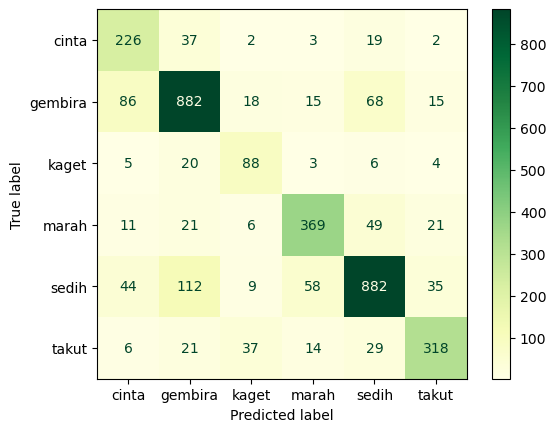

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

normalize = None
# normalize="true"

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize=normalize, cmap="YlGn")